In [1]:
import datetime

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib
from matplotlib import pyplot as plt

%matplotlib inline
sns.set()

In [2]:
from covid_tracking_data.collector import *
from covid_analysis.utility import *
from covid_analysis.models import *

In [3]:
 from matplotlib.axes._axes import _log as matplotlib_axes_logger
 matplotlib_axes_logger.setLevel('ERROR')

### Fetch the latest data

If the interface is overloaded, the collector will retry every few seconds.

In [4]:
df, states_in_order = get_dataset_df()
fns = save_data(df, states_in_order)
print("data saved to {} and {}".format(*fns))

           positive      negative       pending  hospitalized       death  \
count   1034.000000    903.000000    363.000000     67.000000  374.000000   
mean     200.812379   1459.075305    154.085399    183.746269    7.128342   
std     1233.345075   4525.881882    909.482590    576.940424   18.848759   
min        0.000000      0.000000     -3.000000      0.000000    0.000000   
25%        3.000000     48.500000      4.000000      4.000000    0.000000   
50%       18.500000    190.000000     20.000000     27.000000    1.000000   
75%       88.750000    946.000000     76.500000     71.000000    5.000000   
max    25665.000000  65605.000000  12100.000000   3234.000000  210.000000   

              total        order  
count   1037.000000  1037.000000  
mean    1524.626808    25.787850  
std     5440.038830    15.641783  
min        0.000000     0.000000  
25%       41.000000    12.000000  
50%      185.000000    25.000000  
75%      913.000000    39.000000  
max    91270.000000    55.

### Fetch data set from local disk

In [5]:
!ls ~/data/
# gets thte latest file names
recent = ! ls -drt ~/data/* | tail -n 2
print("Latest files are:\n\t{}\n\t{}".format(*recent))

2020-03-24_1744_state_daily_data.csv 2020-03-24_2013_state_daily_data.csv
2020-03-24_1744_state_rank.csv       2020-03-24_2013_state_rank.csv
2020-03-24_1829_state_daily_data.csv 2020-03-24_2046_state_daily_data.csv
2020-03-24_1829_state_rank.csv       2020-03-24_2046_state_rank.csv
Latest files are:
	/Users/drskippy/data/2020-03-24_2046_state_daily_data.csv
	/Users/drskippy/data/2020-03-24_2046_state_rank.csv


In [6]:
df, states_in_order = get_dataset_df_from_file(recent)
df.head()

,date,state,positive,negative,pending,hospitalized,death,total,dateChecked,order,lastUpdateEt
0,2020-03-04,NY,6.0,48.0,24.0,NaN,NaN,78,2020-03-04 21:00:00+00:00,0,2020-03-24 11:30:00
1,2020-03-05,NY,22.0,76.0,24.0,NaN,NaN,122,2020-03-05 21:00:00+00:00,0,2020-03-24 11:30:00
2,2020-03-06,NY,33.0,92.0,236.0,NaN,NaN,361,2020-03-06 21:00:00+00:00,0,2020-03-24 11:30:00
3,2020-03-07,NY,76.0,92.0,236.0,NaN,NaN,404,2020-03-07 21:00:00+00:00,0,2020-03-24 11:30:00
4,2020-03-08,NY,105.0,92.0,NaN,NaN,NaN,197,2020-03-08 20:00:00+00:00,0,2020-03-24 11:30:00


### Zero-day normalized log plots

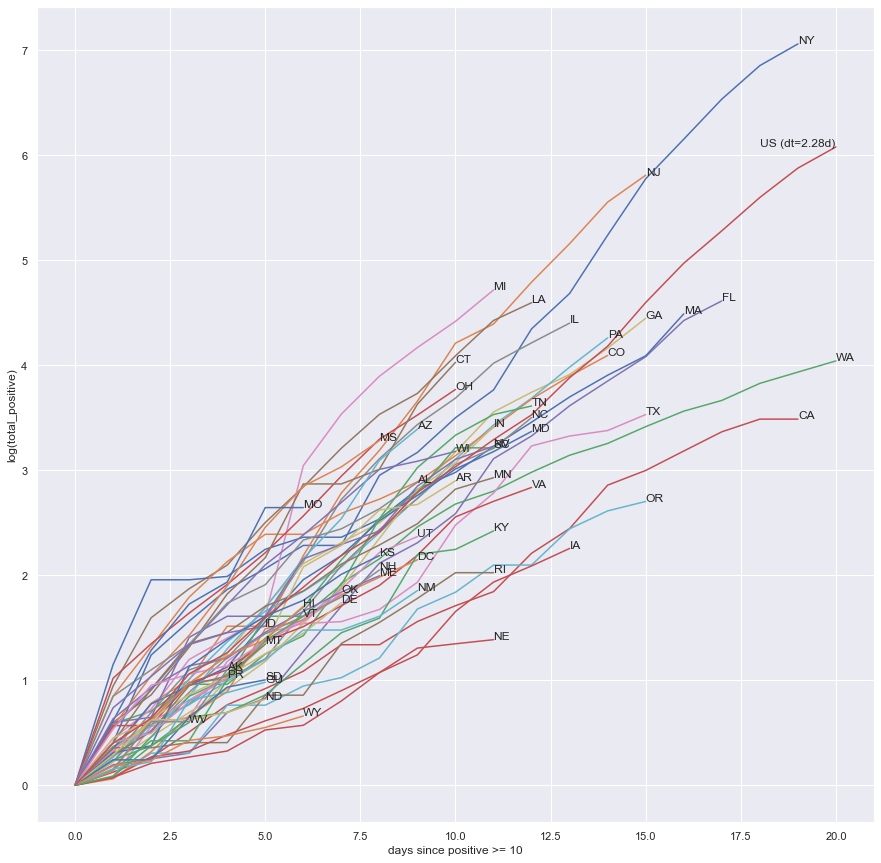

In [7]:
# start after day with min_pos or more cases
min_pos = 10
last_n_days = None

# image
plt.figure(figsize=[15,15])

# state by state
for s in states_in_order:
    try:
        dfq, dt, lud = get_state_doubling_df(df, s, zero_aligned=True, min_pos=min_pos, use_last_n_days=last_n_days)
        plt.plot(dfq["days_since_{}".format(min_pos)].values, dfq.log_positive.values)
        plt.annotate(s, (dfq["days_since_{}".format(min_pos)].values[-1], dfq.log_positive.values[-1]))
    except IndexError:
        pass

# All US image
try:
    dfq, dt, lud = get_state_doubling_df(df, "*", zero_aligned=True, min_pos=min_pos, use_last_n_days=last_n_days)
    plt.plot(dfq["days_since_{}".format(min_pos)].values, dfq.log_positive.values)
    xus = int(.9* dfq["days_since_{}".format(min_pos)].values[-1])
    plt.annotate("US (dt={:1.2f}d)".format(dt), (xus , dfq.log_positive.values[-1]))
except IndexError:
    pass

plt.xlabel("days since positive >= {}".format(min_pos))
plt.ylabel("log(total_positive)")
plt.show()

### US Totals and Doubling Times

US Total Positive, doubling every 2.23 days
  as of 2020-03-24T13:00
  based on last 14 days of data


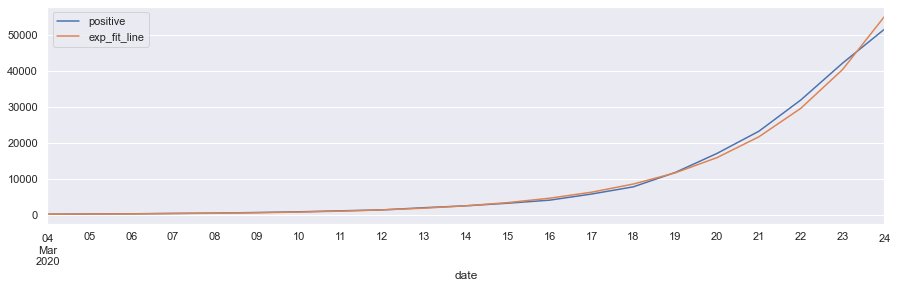

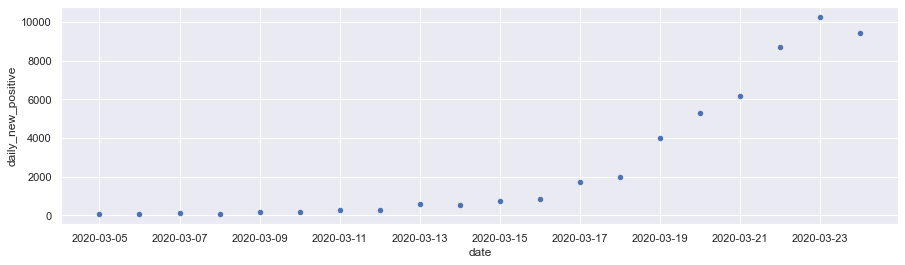

In [8]:
last_n_days = 14
dfa, dt, lud = get_state_doubling_df(df, "*", use_last_n_days=last_n_days)
lu = str(lud)[:16]
print("US Total Positive, doubling every {:.3} days\n  as of {}".format(dt, lu))
print("  based on last {} days of data".format(last_n_days))
dfa.plot(x="date", y=["positive", "exp_fit_line"], figsize=[15,4])
dfa.plot.scatter(x="date", y="daily_new_positive", figsize=[15,4])
plt.show()

### Model of acutal infections with set perscentage of symptomatic or untested

MODEL: US Total Positive, doubling every 2.19 days
(2020-03-24T13:00)


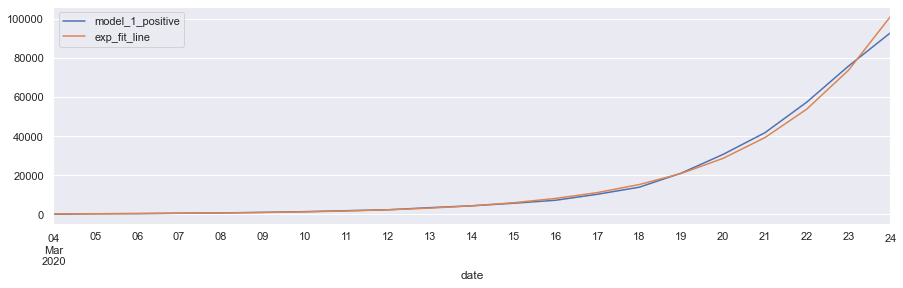

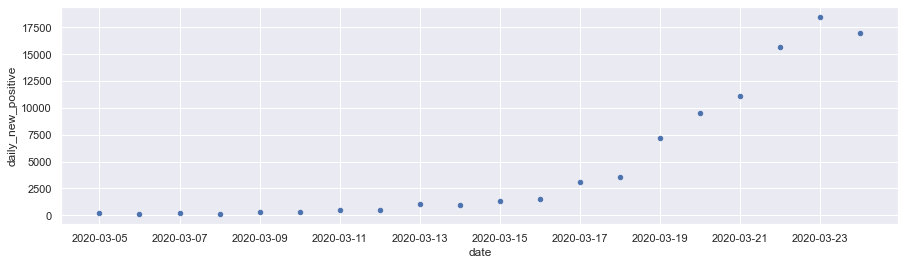

In [9]:
# model of acutals
dfm = model_1_actual_infections(dfa, "*")
dfma, dtm, _ = get_state_doubling_df(dfm, "*", pos_key="model_1_positive")
dfma.plot(x="date", y=["model_1_positive", "exp_fit_line"], figsize=[15,4])
lu = str(lud)[:16]
print("MODEL: US Total Positive, doubling every {:.3} days\n({})".format(dtm, lu))
dfma.plot.scatter(x="date", y="daily_new_positive", figsize=[15,4])
plt.show()

### Current measured ratios and percentages

These are based on cases that test postive and test negative (state labs policies vary on this).

In [10]:
print("Current strategies for diagnosis give pos/neg tests ratio of {:.1%}".format(
    df.positive.sum()/(df.positive.sum() + df.negative.sum())))
print("on total tests tracked = {:,}".format(int(df.positive.sum() + df.negative.sum())))

Current strategies for diagnosis give pos/neg tests ratio of 13.6%
on total tests tracked = 1,525,185


In [11]:
pos_dr = df.death.sum()/df.positive.sum()
print("Current death/positive ratio of {:.1%}".format(pos_dr))

Current death/positive ratio of 1.3%


In [12]:
# projections of exp growth
print("US flu death rate average per month = 61,099/12 ≈ {}".format(int(61099/12)))
print("Using doubling time of {:2.2f} days".format(dt))
print("period      date         positive,     deaths              weekly rate")
print("-------------------------------------------------------------------------------------")
now, v = dfa[-1:][["date", "positive"]].values[0]
start, _ = dfa[1:][["date", "positive"]].values[0]
time_in_weeks = (now - start).total_seconds()/(86400*7)
pstr = "{:4}: {:%Y-%m-%d %H h}, {:10,d} [total deaths {:6,d}] Death Rate Avg = {:,d} per wk"
print(pstr.format(0, now, int(v), int(v*pos_dr), int(v*pos_dr/time_in_weeks)))

ddt = datetime.timedelta(days=dt)
for i in range(1,5):
    t = now + i*ddt
    time_in_weeks = (t - start).total_seconds()/(86400*7)
    v *= 2
    print(pstr.format(i,t,int(v), int(v*pos_dr), int(v*pos_dr/time_in_weeks)))
    

US flu death rate average per month = 61,099/12 ≈ 5091
Using doubling time of 2.23 days
period      date         positive,     deaths              weekly rate
-------------------------------------------------------------------------------------
   0: 2020-03-24 00 h,     51,601 [total deaths    662] Death Rate Avg = 244 per wk
   1: 2020-03-26 05 h,    103,202 [total deaths  1,325] Death Rate Avg = 436 per wk
   2: 2020-03-28 10 h,    206,404 [total deaths  2,650] Death Rate Avg = 791 per wk
   3: 2020-03-30 16 h,    412,808 [total deaths  5,300] Death Rate Avg = 1,444 per wk
   4: 2020-04-01 21 h,    825,616 [total deaths 10,600] Death Rate Avg = 2,659 per wk


### State Trends and Doubling Periods

State=NY  (last_update=2020-03-24T11:30)
Doubling every 1.74 days based on last 14 days of data
(naive estimates: current_unresolved=25141 hosp=3771 icu=1005)


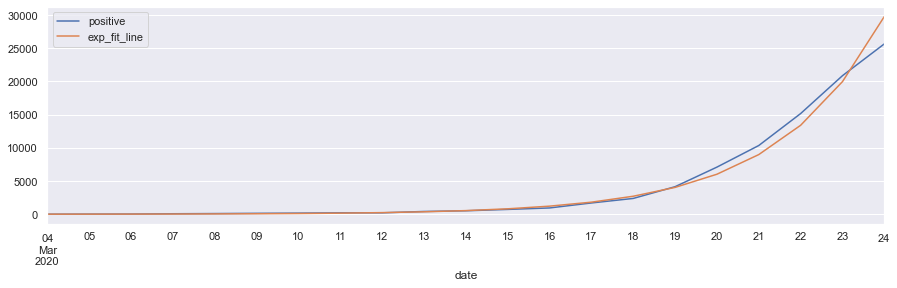

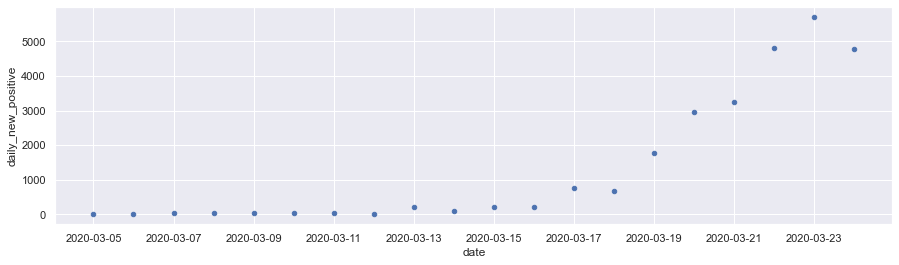

State=NJ  (last_update=2020-03-23T14:00)
Doubling every 1.69 days based on last 14 days of data
(naive estimates: current_unresolved=3625 hosp=543 icu=145)


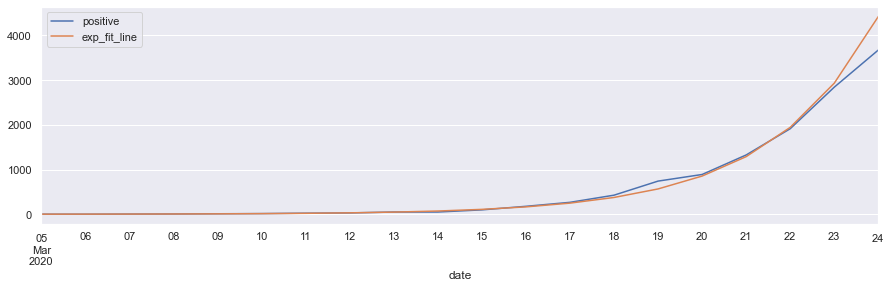

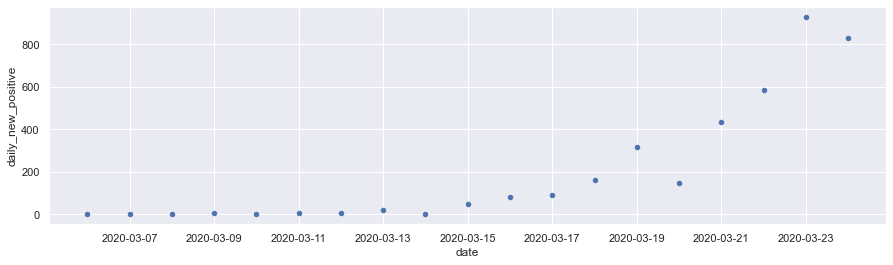

State=WA  (last_update=2020-03-23T18:07)
Doubling every 4.41 days based on last 14 days of data
(naive estimates: current_unresolved=1653 hosp=247 icu=66)


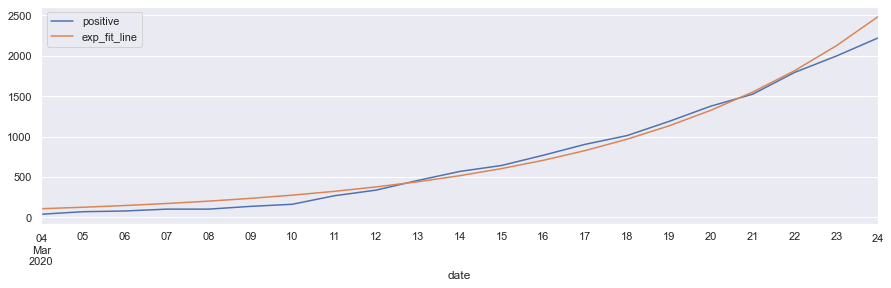

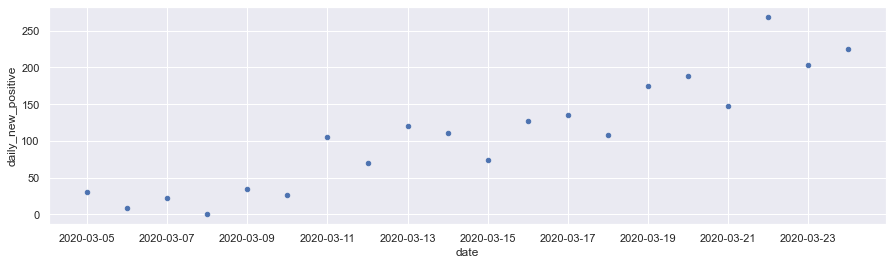

State=CA  (last_update=2020-03-23T00:00)
Doubling every 3.35 days based on last 14 days of data
(naive estimates: current_unresolved=1481 hosp=222 icu=59)


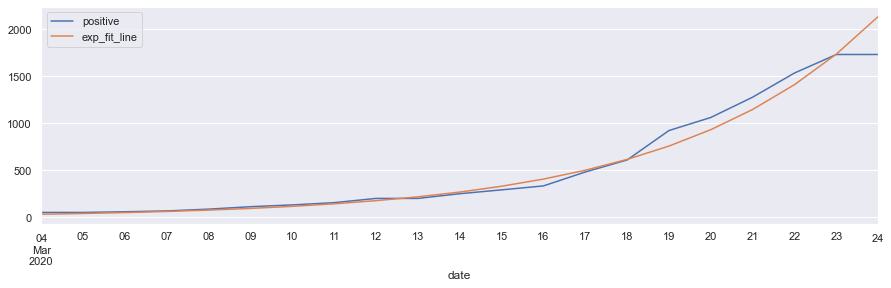

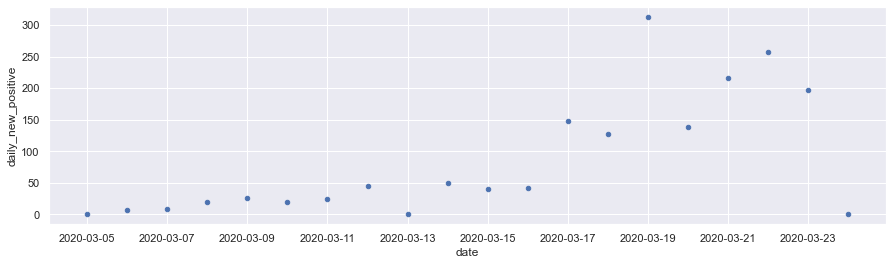

State=FL  (last_update=2020-03-24T11:00)
Doubling every 2.22 days based on last 14 days of data
(naive estimates: current_unresolved=1335 hosp=200 icu=53)


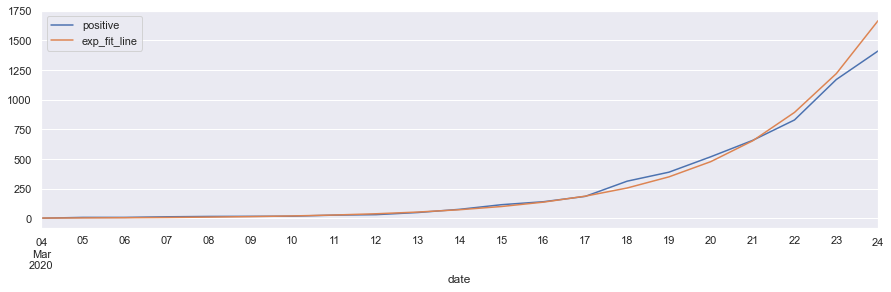

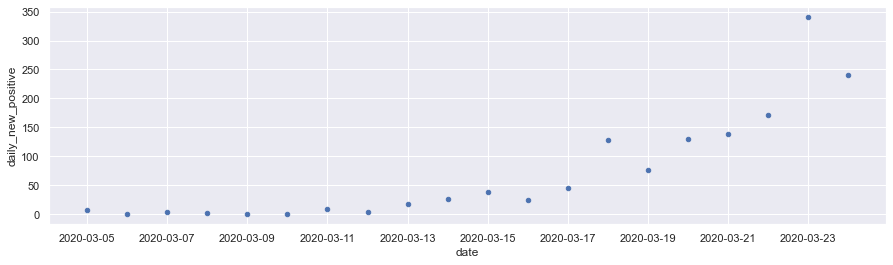

State=LA  (last_update=2020-03-23T13:00)
Doubling every 1.8 days based on last 14 days of data
(naive estimates: current_unresolved=1319 hosp=197 icu=52)


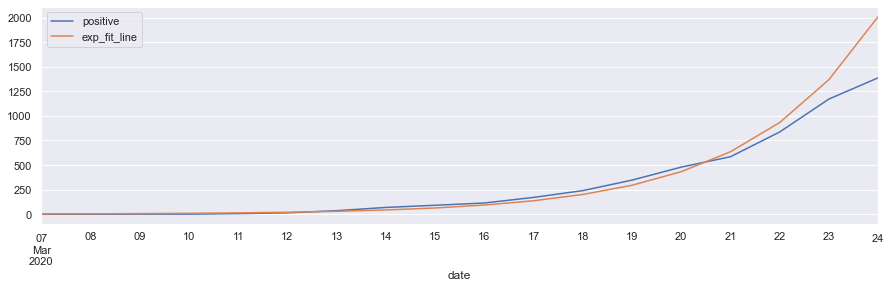

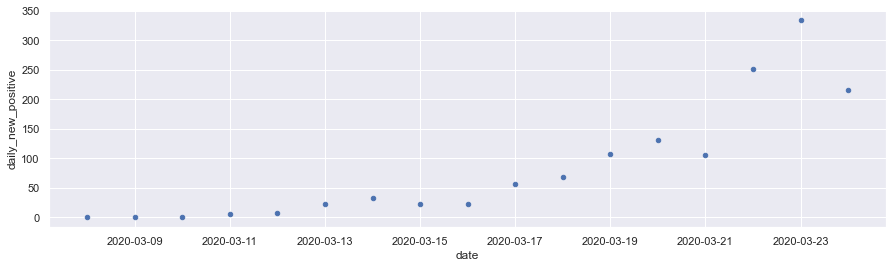

State=MI  (last_update=2020-03-23T11:00)
Doubling every 1.31 days based on last 14 days of data
(naive estimates: current_unresolved=1766 hosp=264 icu=70)


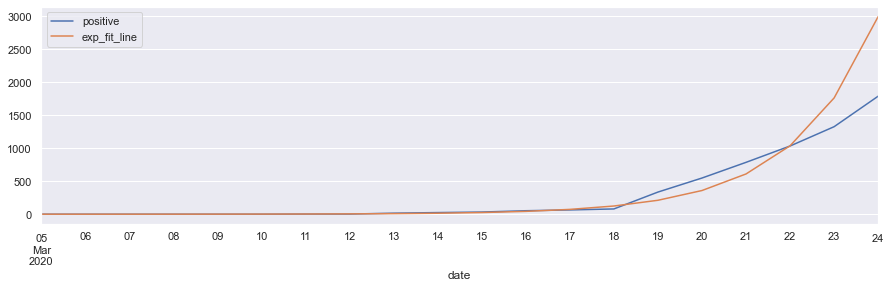

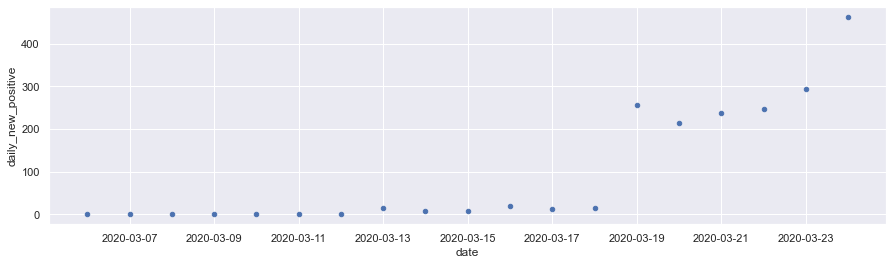

State=IL  (last_update=2020-03-23T00:00)
Doubling every 1.88 days based on last 14 days of data
(naive estimates: current_unresolved=1505 hosp=225 icu=60)


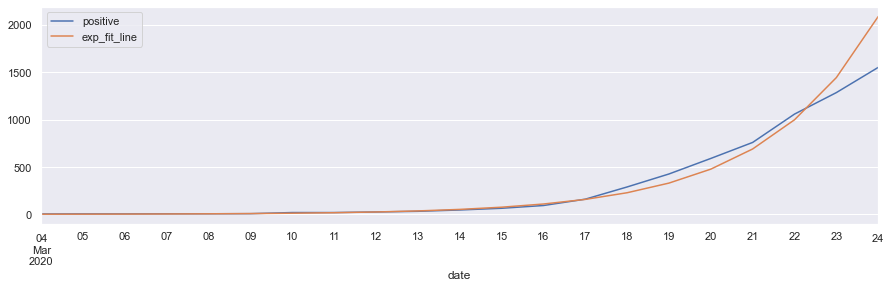

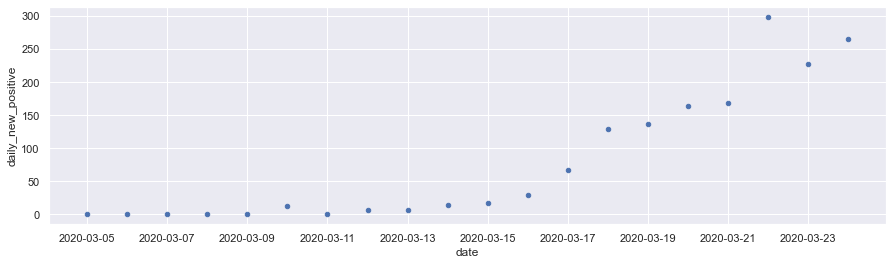

State=GA  (last_update=2020-03-24T12:00)
Doubling every 2.36 days based on last 14 days of data
(naive estimates: current_unresolved=960 hosp=144 icu=38)


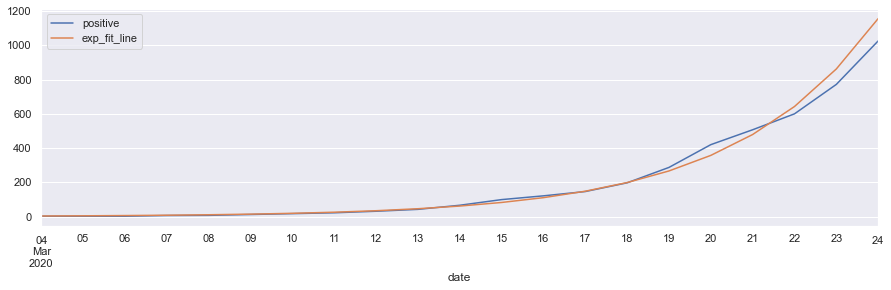

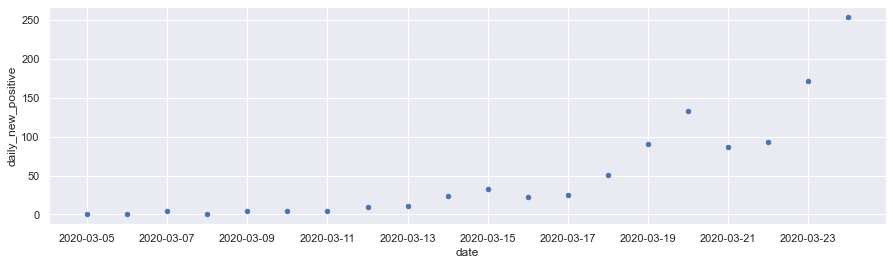

State=PA  (last_update=2020-03-24T12:00)
Doubling every 2.28 days based on last 14 days of data
(naive estimates: current_unresolved=804 hosp=120 icu=32)


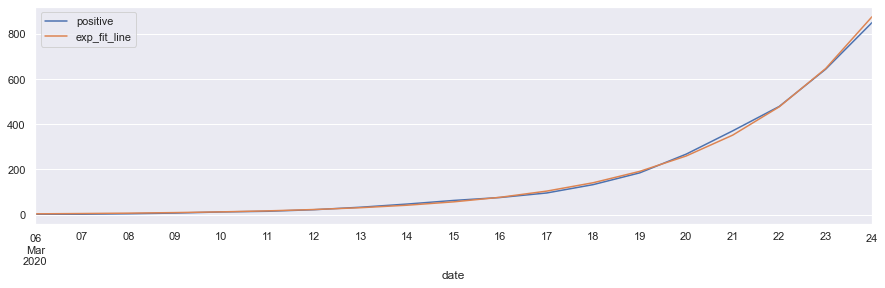

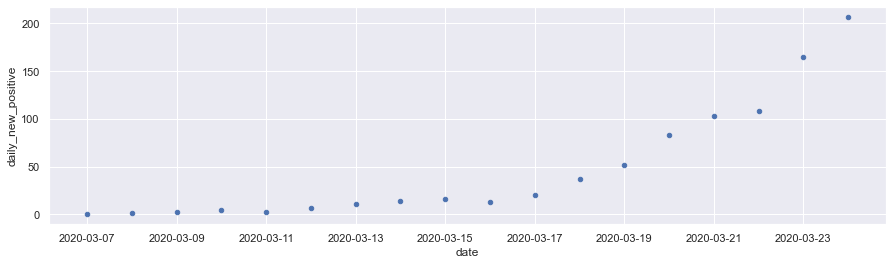

State=MA  (last_update=2020-03-23T12:30)
Doubling every 3.58 days based on last 14 days of data
(naive estimates: current_unresolved=1021 hosp=153 icu=40)


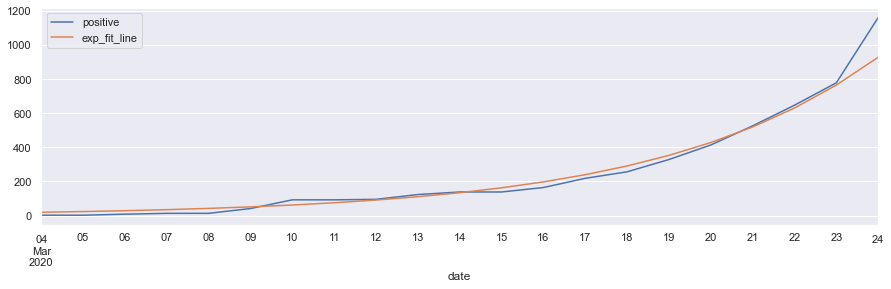

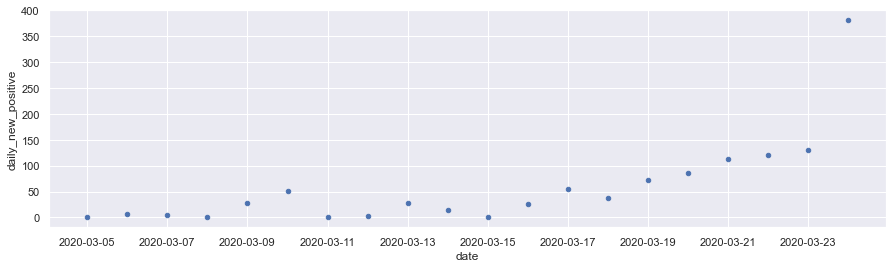

State=CO  (last_update=2020-03-23T18:13)
Doubling every 3.1 days based on last 14 days of data
(naive estimates: current_unresolved=619 hosp=92 icu=24)


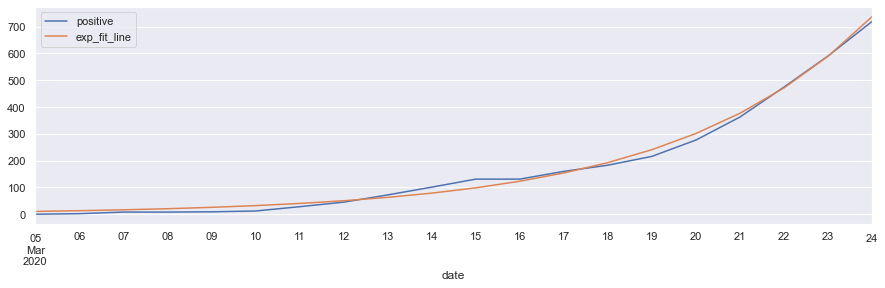

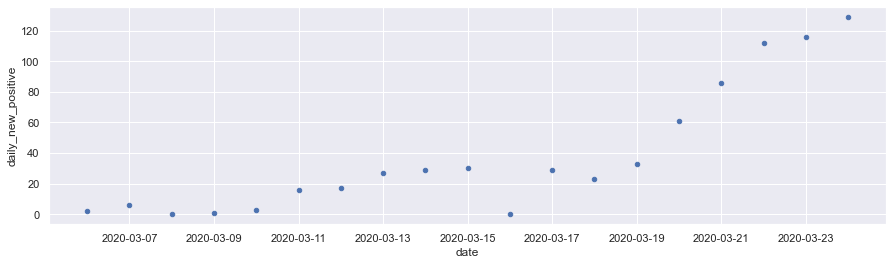

State=TN  (last_update=2020-03-23T15:00)
Doubling every 2.04 days based on last 14 days of data
(naive estimates: current_unresolved=635 hosp=95 icu=25)


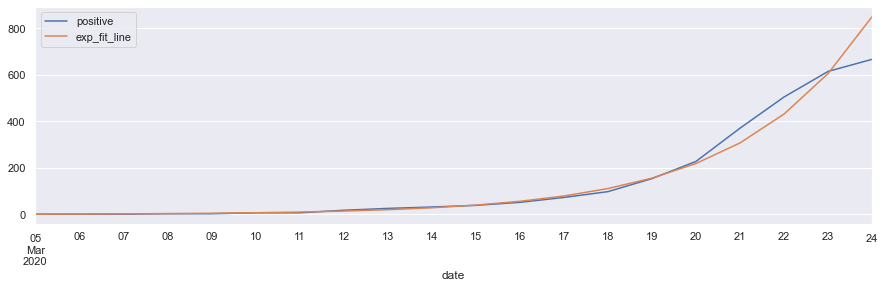

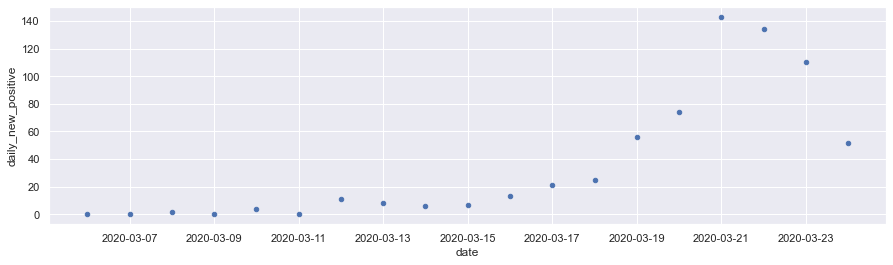

State=OH  (last_update=2020-03-23T14:00)
Doubling every 1.81 days based on last 14 days of data
(naive estimates: current_unresolved=551 hosp=82 icu=22)


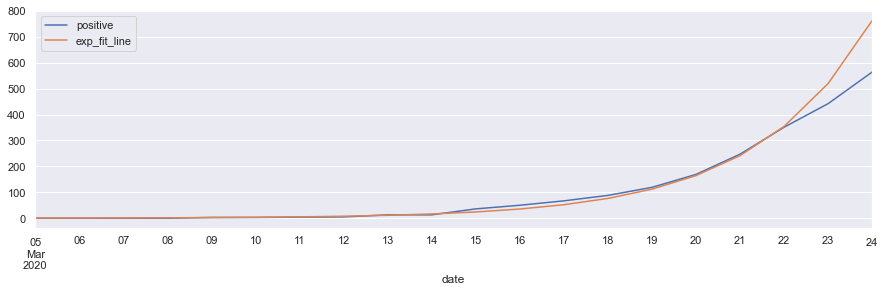

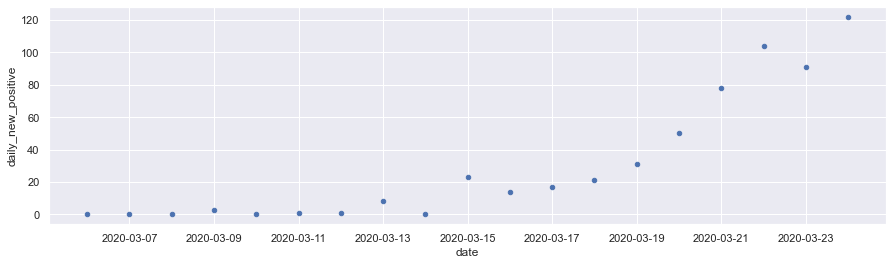

State=WI  (last_update=2020-03-23T16:00)
Doubling every 1.88 days based on last 14 days of data
(naive estimates: current_unresolved=438 hosp=65 icu=17)


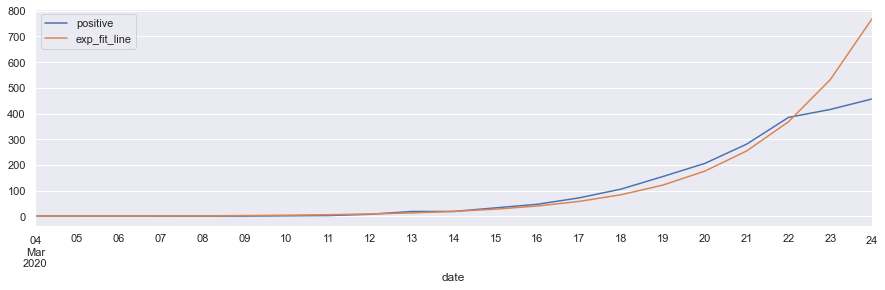

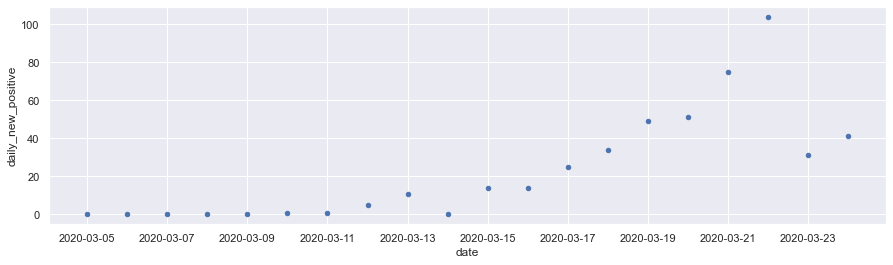

State=CT  (last_update=2020-03-23T16:00)
Doubling every 1.71 days based on last 14 days of data
(naive estimates: current_unresolved=607 hosp=91 icu=24)


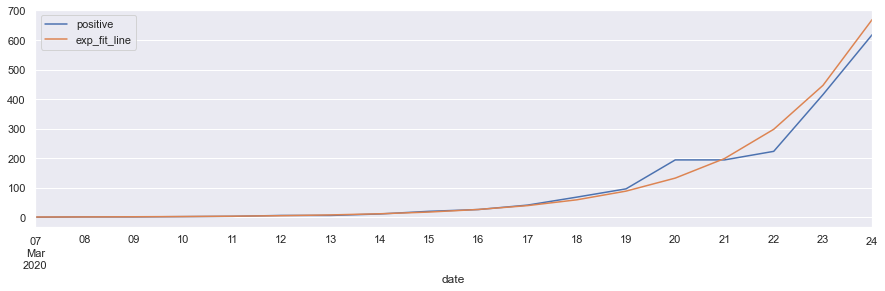

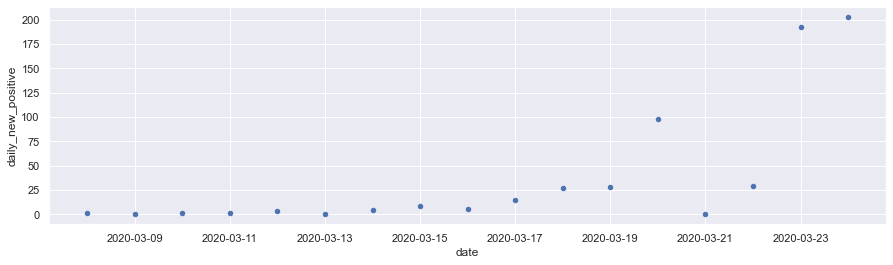

State=TX  (last_update=2020-03-23T21:00)
Doubling every 2.88 days based on last 14 days of data
(naive estimates: current_unresolved=359 hosp=53 icu=14)


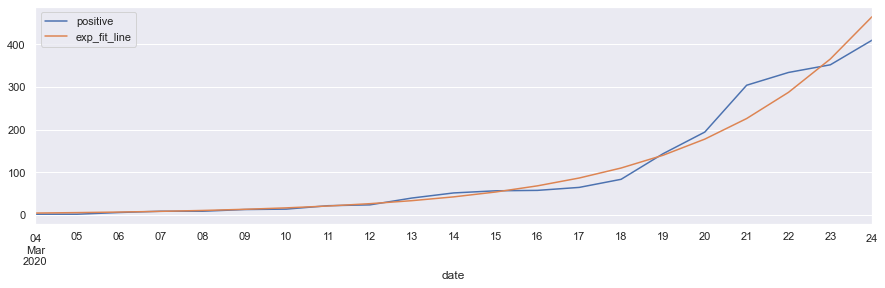

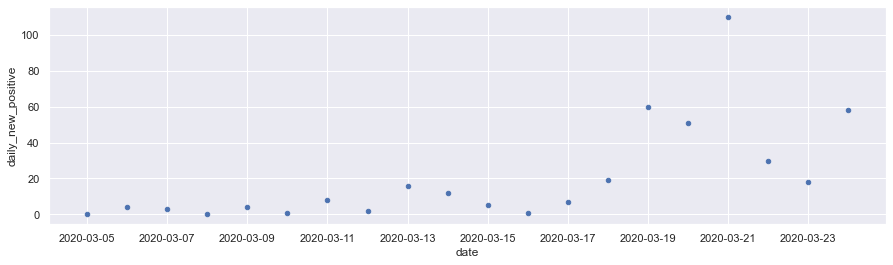

State=NC  (last_update=2020-03-24T09:45)
Doubling every 2.27 days based on last 14 days of data
(naive estimates: current_unresolved=375 hosp=56 icu=15)


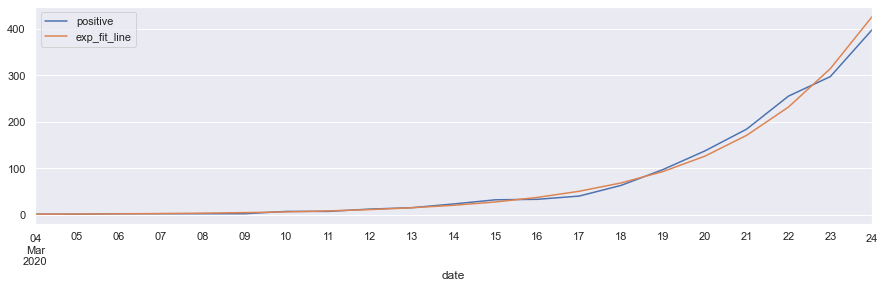

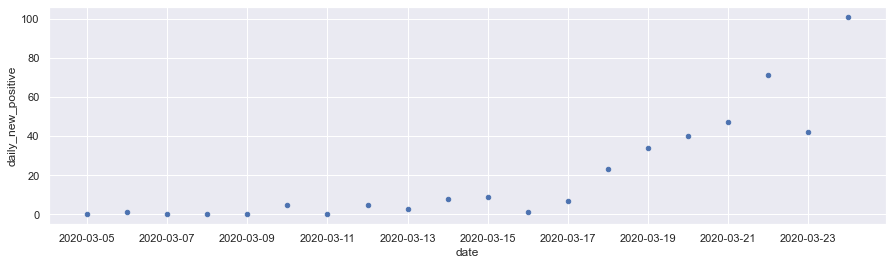

State=IN  (last_update=2020-03-24T11:00)
Doubling every 2.41 days based on last 14 days of data
(naive estimates: current_unresolved=350 hosp=52 icu=14)


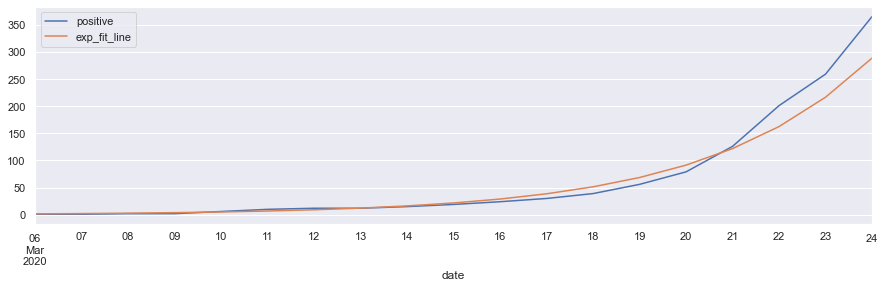

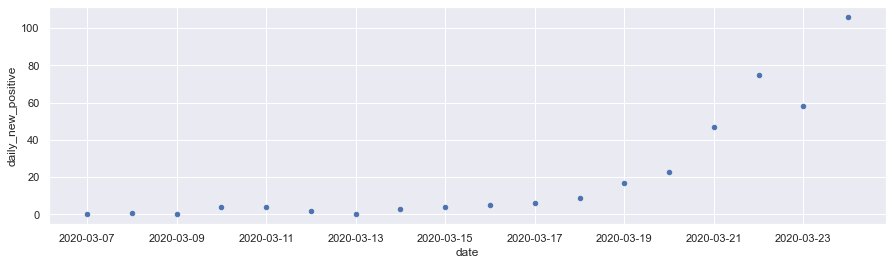

State=AZ  (last_update=2020-03-24T00:00)
Doubling every 2.3 days based on last 14 days of data
(naive estimates: current_unresolved=345 hosp=51 icu=13)


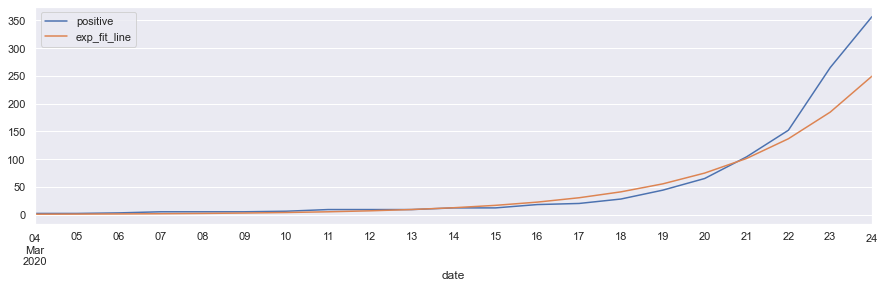

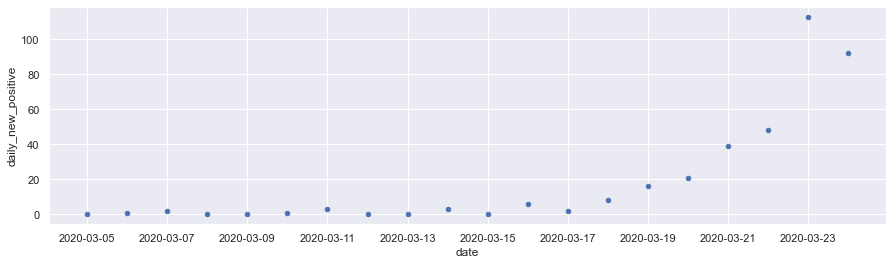

State=MD  (last_update=2020-03-24T10:00)
Doubling every 2.39 days based on last 14 days of data
(naive estimates: current_unresolved=323 hosp=48 icu=12)


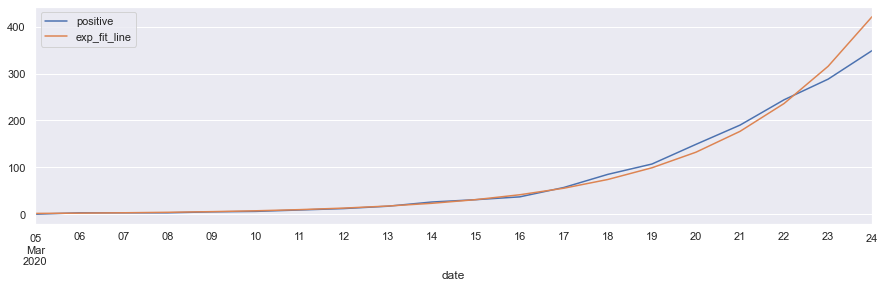

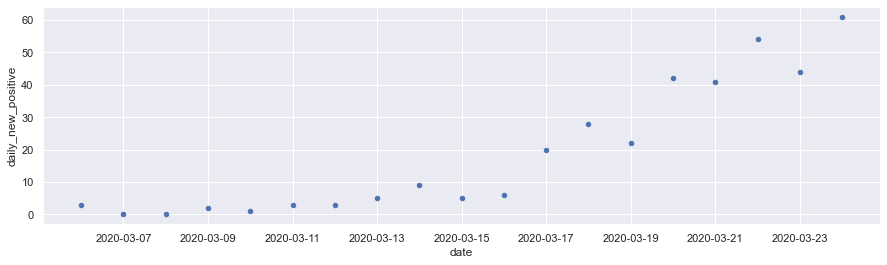

State=MS  (last_update=2020-03-23T19:00)
Doubling every 1.54 days based on last 14 days of data
(naive estimates: current_unresolved=314 hosp=47 icu=12)


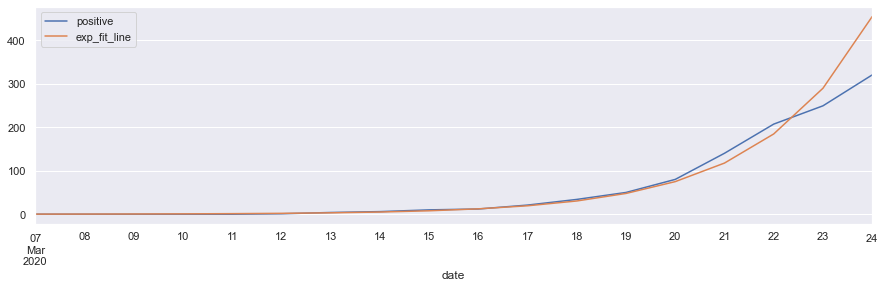

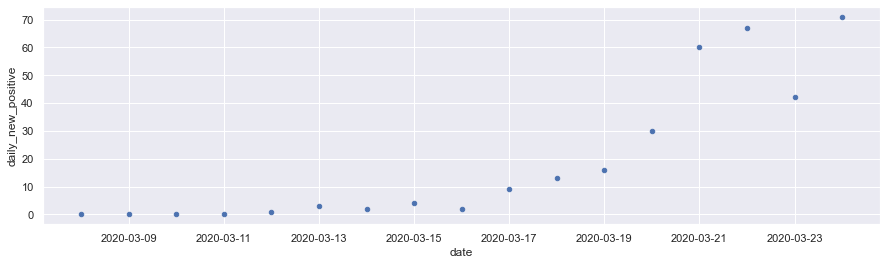

State=SC  (last_update=2020-03-23T17:18)
Doubling every 2.33 days based on last 14 days of data
(naive estimates: current_unresolved=285 hosp=42 icu=11)


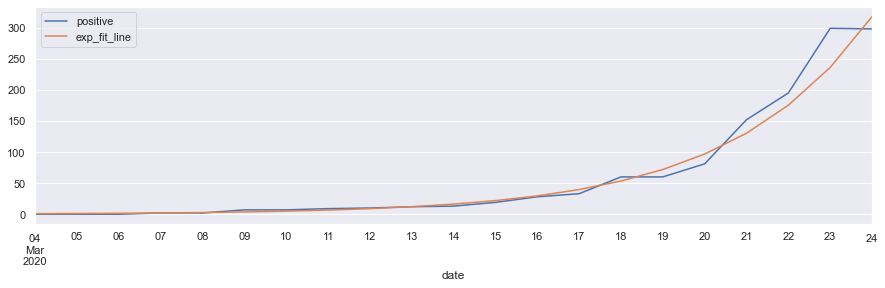

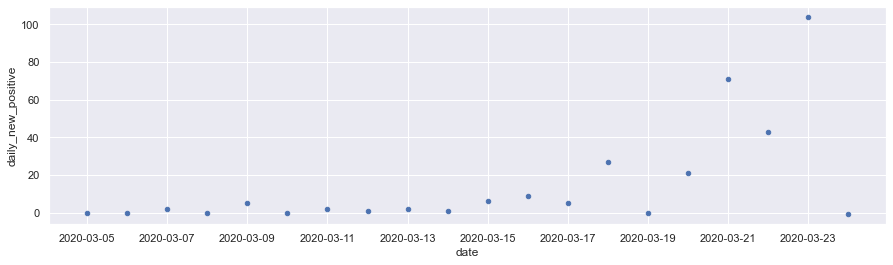

State=VA  (last_update=2020-03-24T00:00)
Doubling every 2.85 days based on last 14 days of data
(naive estimates: current_unresolved=260 hosp=39 icu=10)


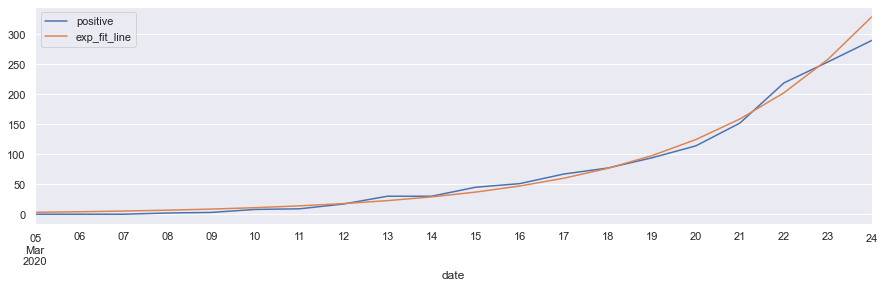

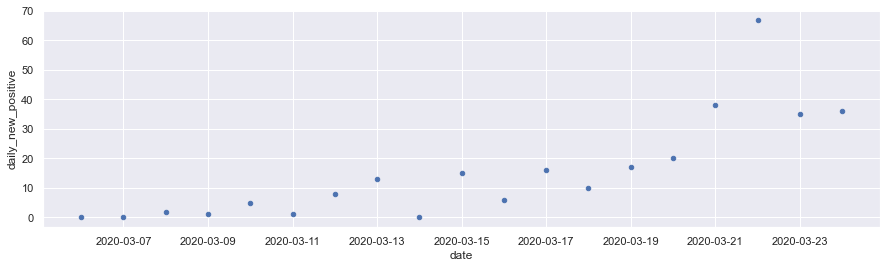

State=NV  (last_update=2020-03-23T14:59)
Doubling every 2.25 days based on last 14 days of data
(naive estimates: current_unresolved=258 hosp=38 icu=10)


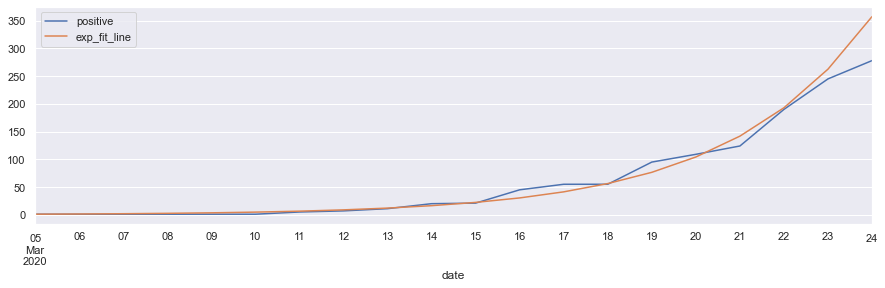

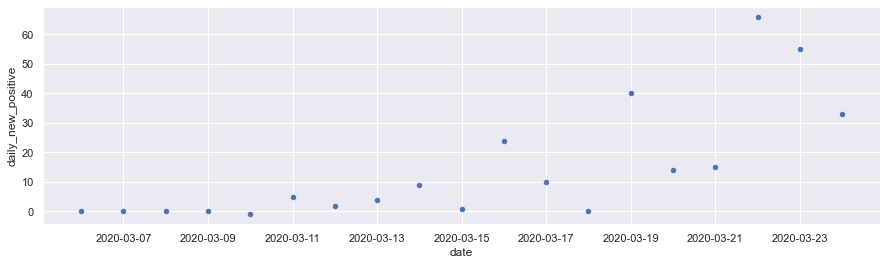

State=MN  (last_update=2020-03-24T00:00)
Doubling every 2.41 days based on last 14 days of data
(naive estimates: current_unresolved=241 hosp=36 icu=9)


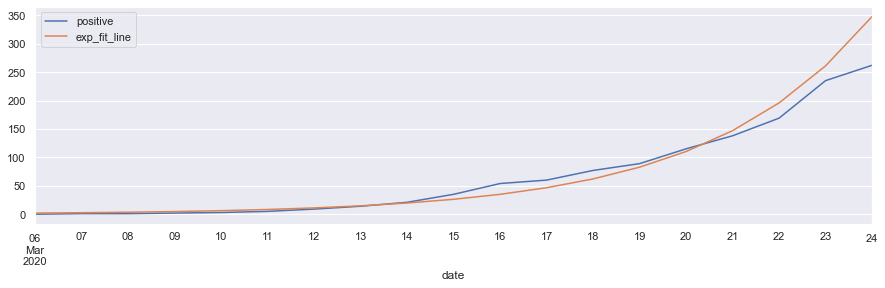

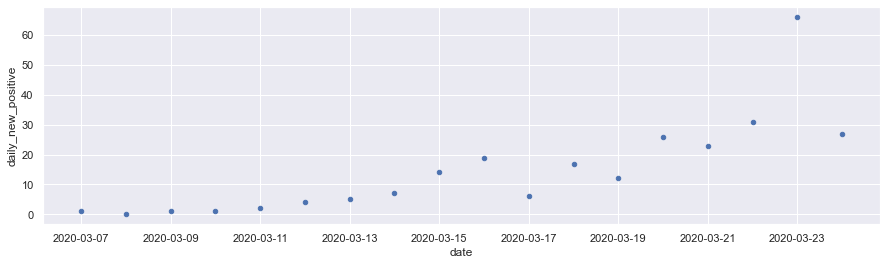

State=UT  (last_update=2020-03-23T15:00)
Doubling every 1.83 days based on last 14 days of data
(naive estimates: current_unresolved=293 hosp=43 icu=11)


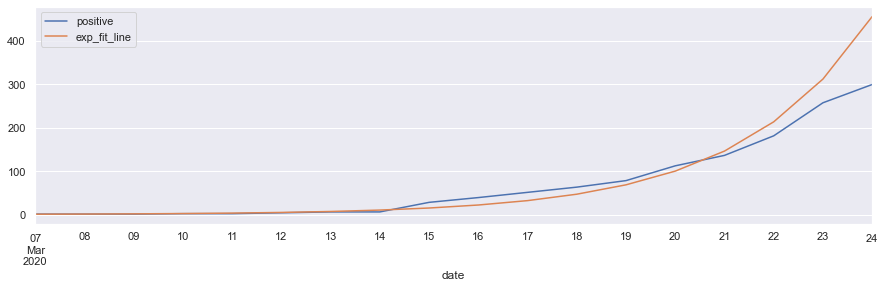

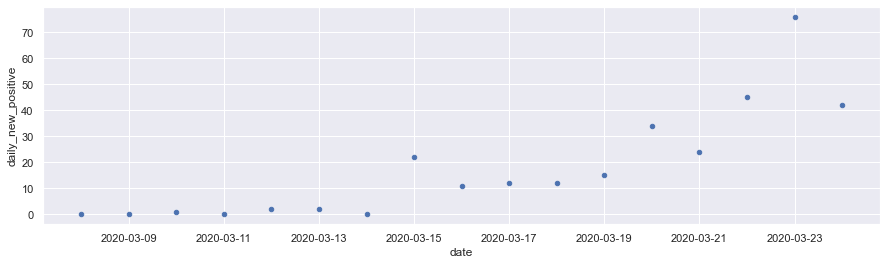

State=AL  (last_update=2020-03-24T12:00)
Doubling every 1.7 days based on last 14 days of data
(naive estimates: current_unresolved=209 hosp=31 icu=8)


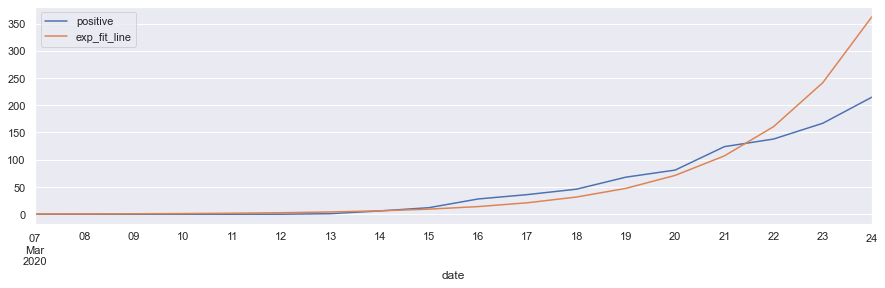

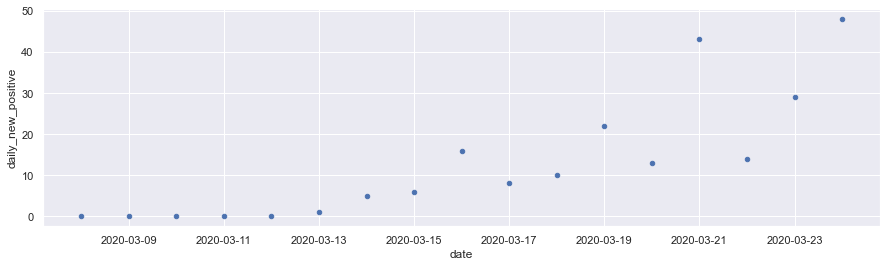

State=AR  (last_update=2020-03-24T00:00)
Doubling every 2.23 days based on last 14 days of data
(naive estimates: current_unresolved=206 hosp=30 icu=8)


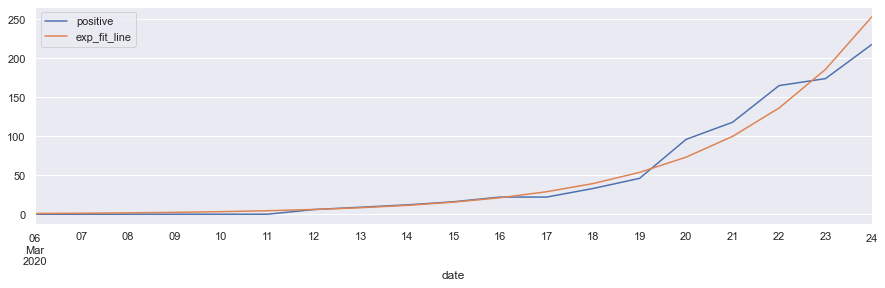

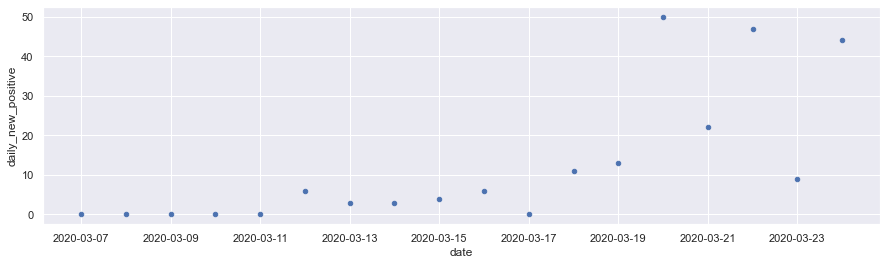

State=OR  (last_update=2020-03-23T11:00)
Doubling every 3.52 days based on last 14 days of data
(naive estimates: current_unresolved=179 hosp=26 icu=7)


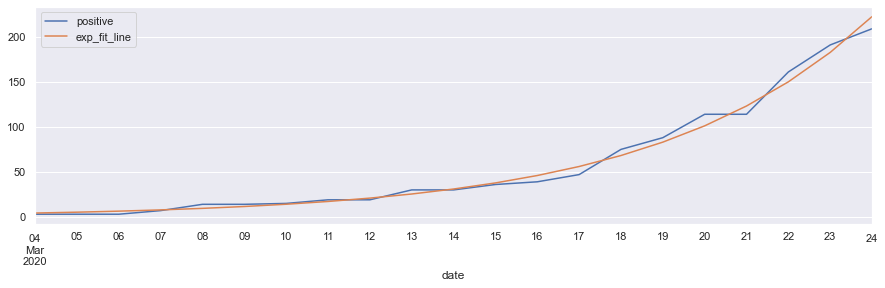

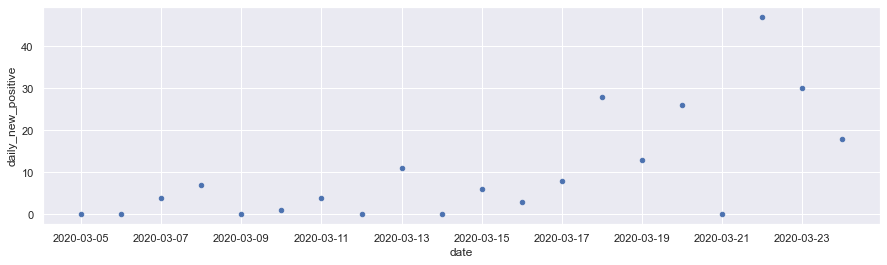

State=MO  (last_update=2020-03-23T15:00)
Doubling every 1.61 days based on last 14 days of data
(naive estimates: current_unresolved=179 hosp=26 icu=7)


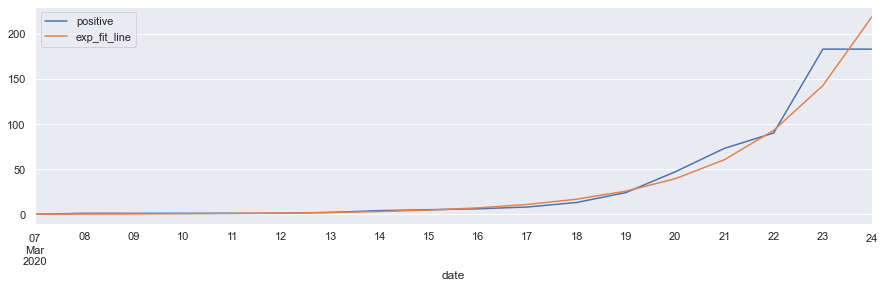

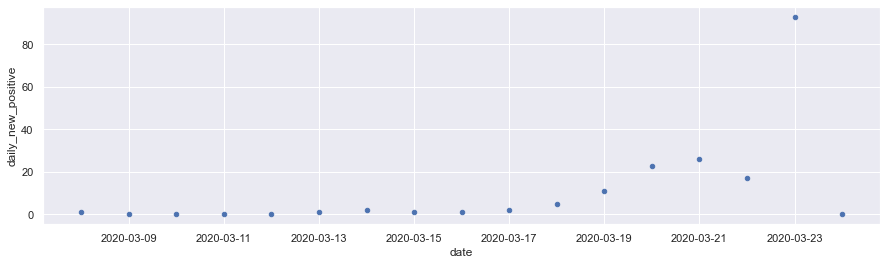

State=DC  (last_update=2020-03-23T19:30)
Doubling every 2.67 days based on last 14 days of data
(naive estimates: current_unresolved=127 hosp=19 icu=5)


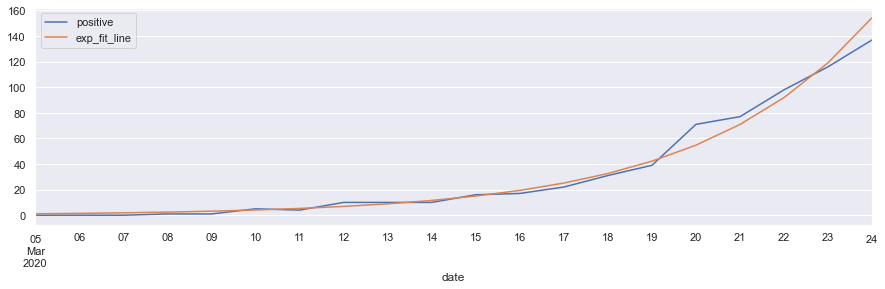

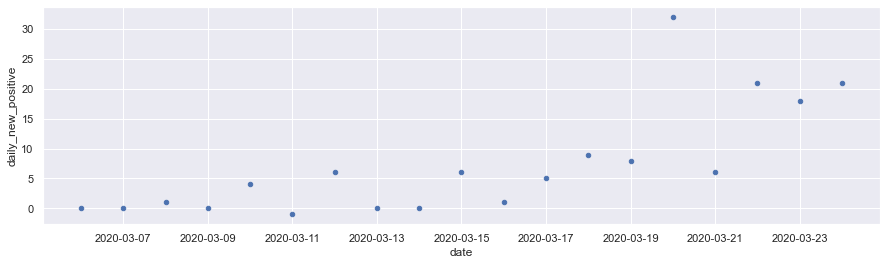

State=KY  (last_update=2020-03-23T17:00)
Doubling every 3.15 days based on last 14 days of data
(naive estimates: current_unresolved=110 hosp=16 icu=4)


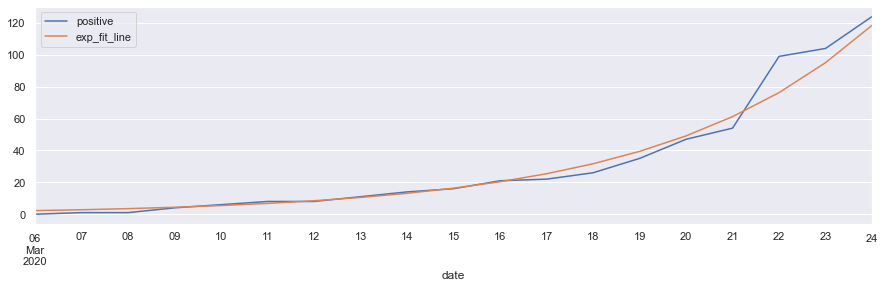

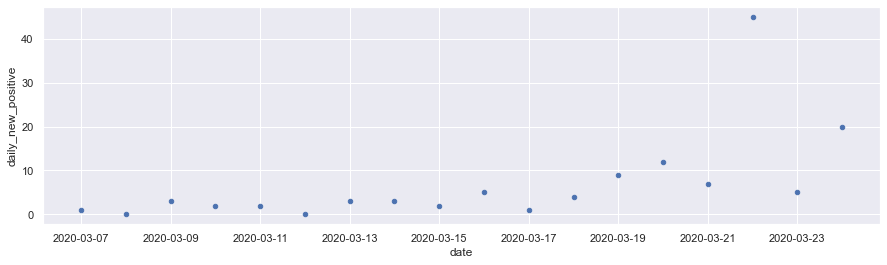

State=IA  (last_update=2020-03-24T00:00)
Doubling every 3.79 days based on last 14 days of data
(naive estimates: current_unresolved=107 hosp=16 icu=4)


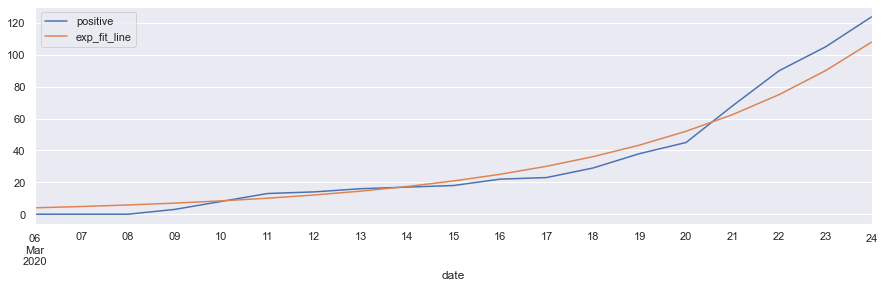

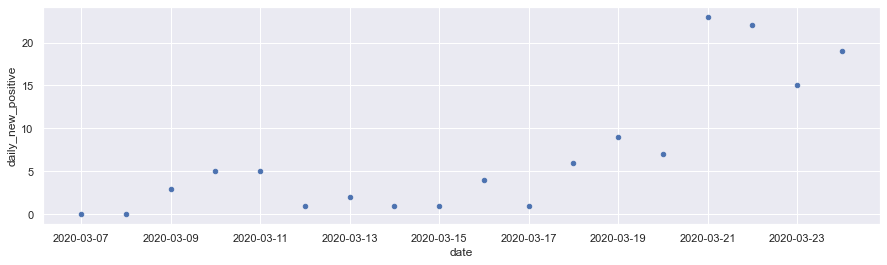

State=ME  (last_update=2020-03-24T12:00)
Doubling every 1.73 days based on last 14 days of data
(naive estimates: current_unresolved=122 hosp=18 icu=4)


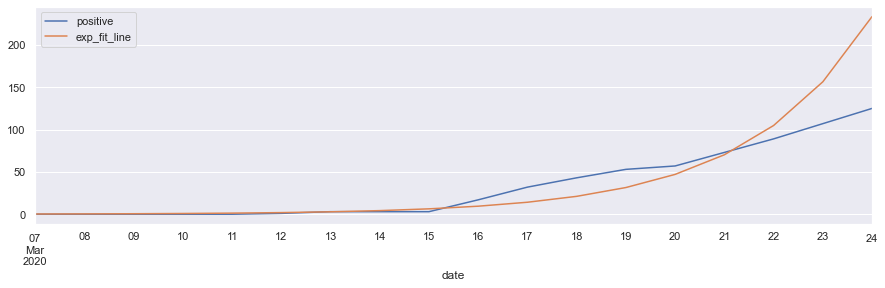

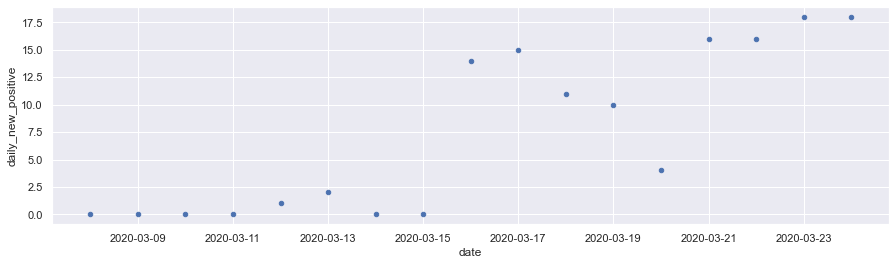

State=RI  (last_update=2020-03-23T00:00)
Doubling every 3.02 days based on last 14 days of data
(naive estimates: current_unresolved=86 hosp=12 icu=3)


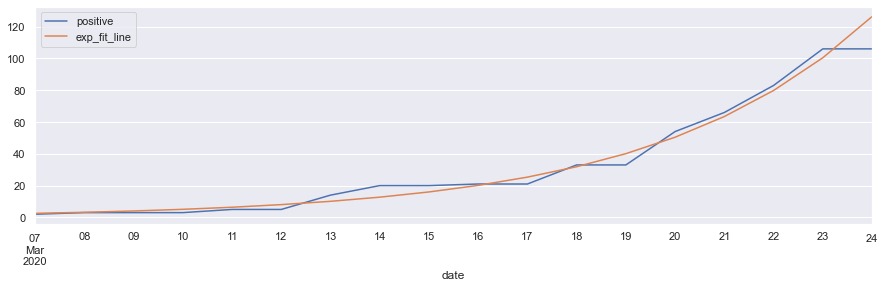

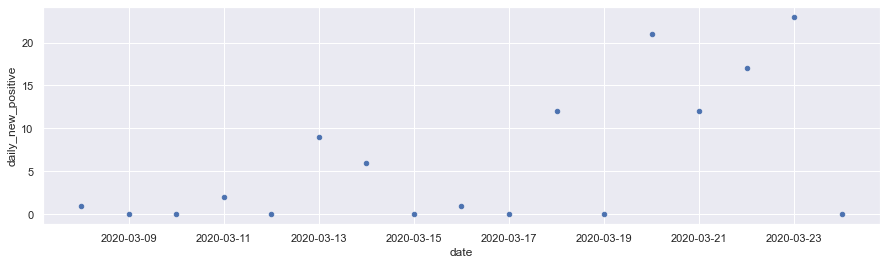

State=OK  (last_update=2020-03-24T08:00)
Doubling every 2.14 days based on last 14 days of data
(naive estimates: current_unresolved=102 hosp=15 icu=4)


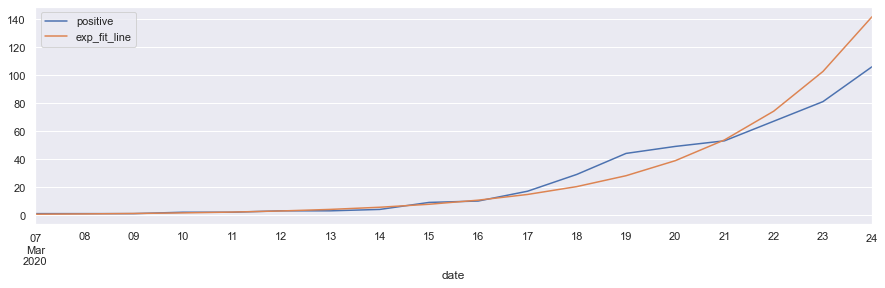

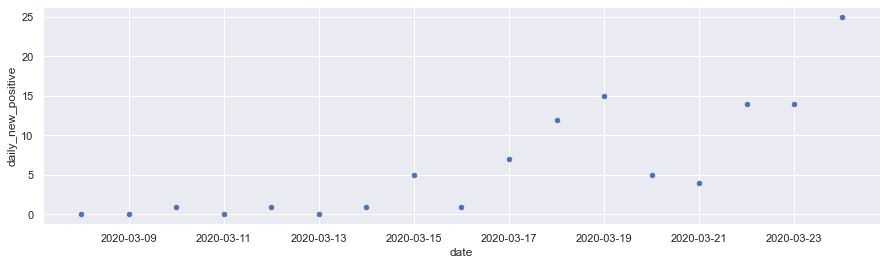

State=NH  (last_update=2020-03-23T09:00)
Doubling every 2.72 days based on last 14 days of data
(naive estimates: current_unresolved=94 hosp=14 icu=3)


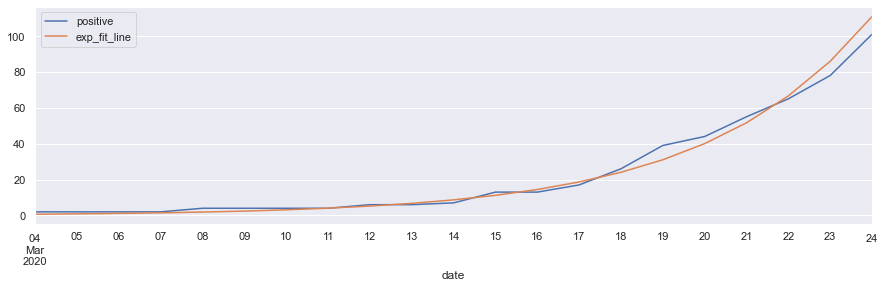

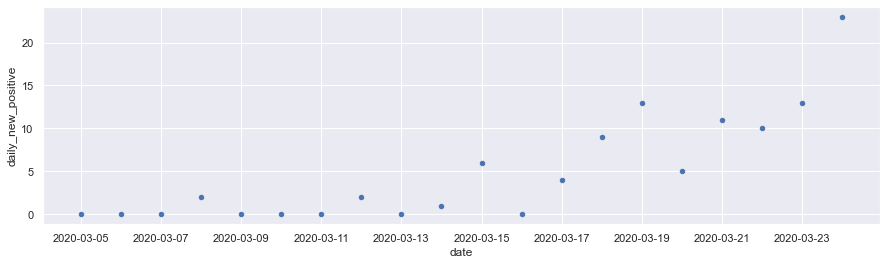

State=DE  (last_update=2020-03-24T10:45)
Doubling every 2.23 days based on last 14 days of data
(naive estimates: current_unresolved=85 hosp=12 icu=3)


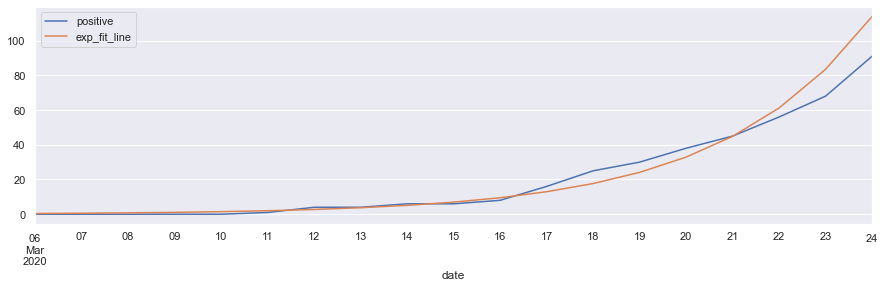

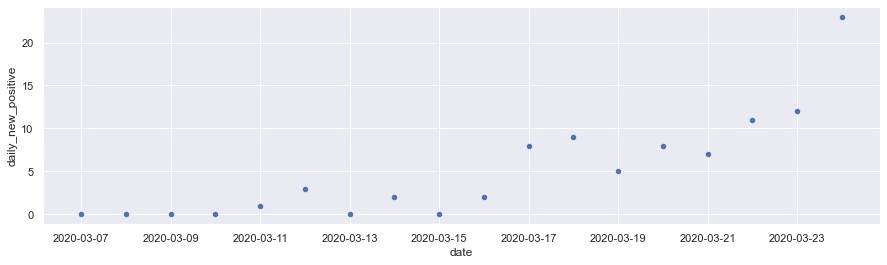

State=NM  (last_update=2020-03-23T00:00)
Doubling every 2.93 days based on last 14 days of data
(naive estimates: current_unresolved=73 hosp=10 icu=2)


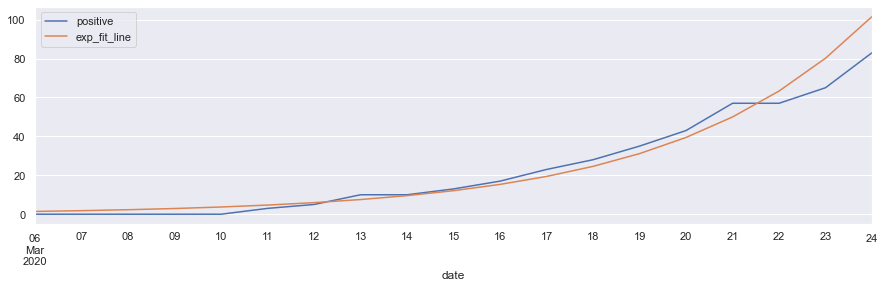

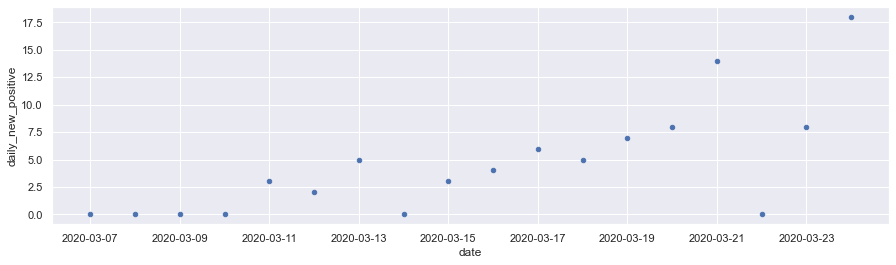

State=KS  (last_update=2020-03-23T11:00)
Doubling every 2.23 days based on last 14 days of data
(naive estimates: current_unresolved=92 hosp=13 icu=3)


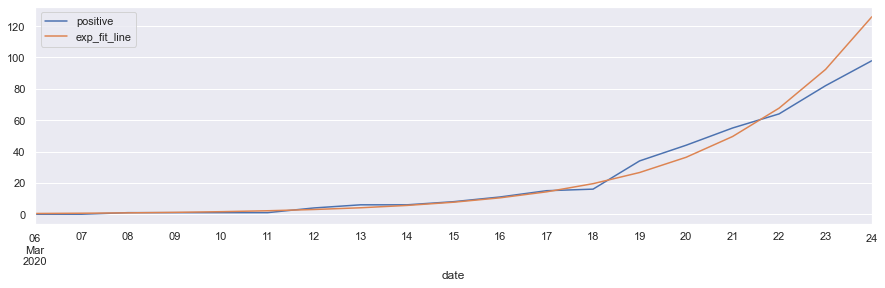

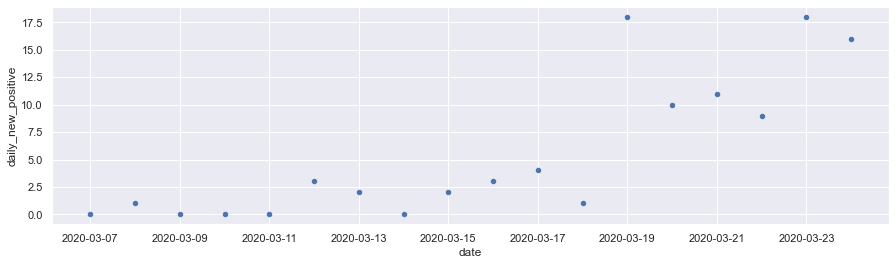

State=HI  (last_update=2020-03-23T18:00)
Doubling every 2.12 days based on last 14 days of data
(naive estimates: current_unresolved=75 hosp=11 icu=3)


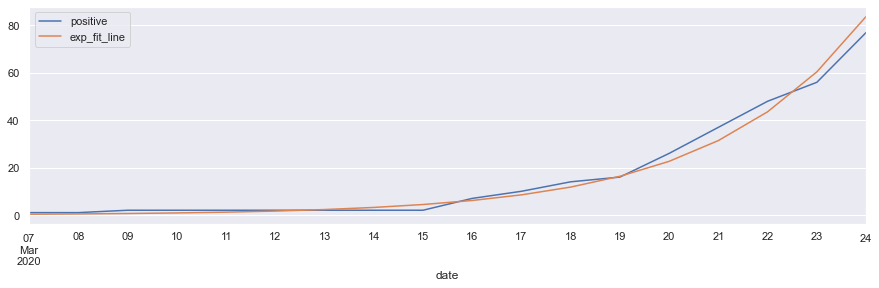

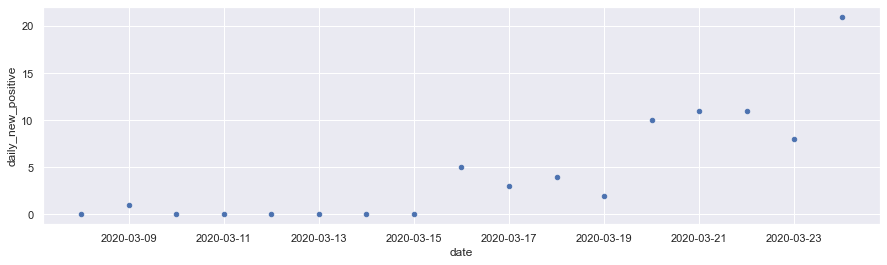

State=VT  (last_update=2020-03-23T13:00)
Doubling every 2.02 days based on last 14 days of data
(naive estimates: current_unresolved=91 hosp=13 icu=3)


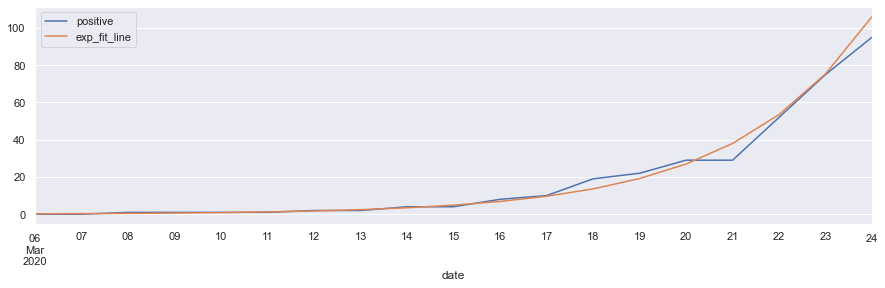

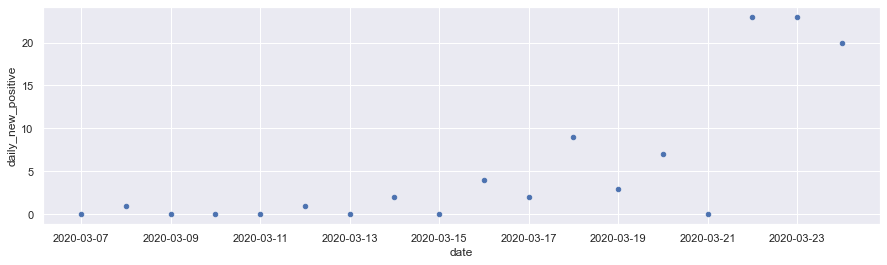

State=NE  (last_update=2020-03-23T00:00)
Doubling every 4.42 days based on last 14 days of data
(naive estimates: current_unresolved=38 hosp=5 icu=1)


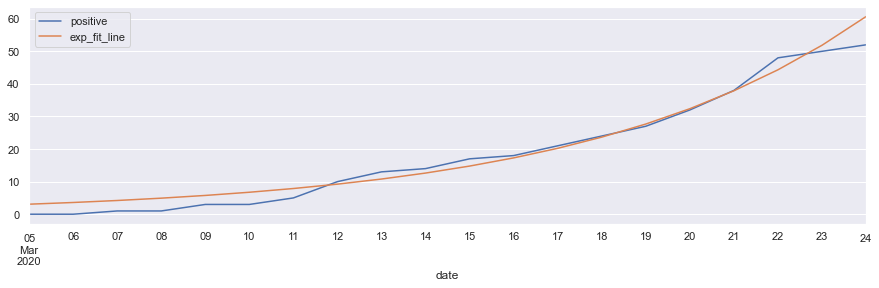

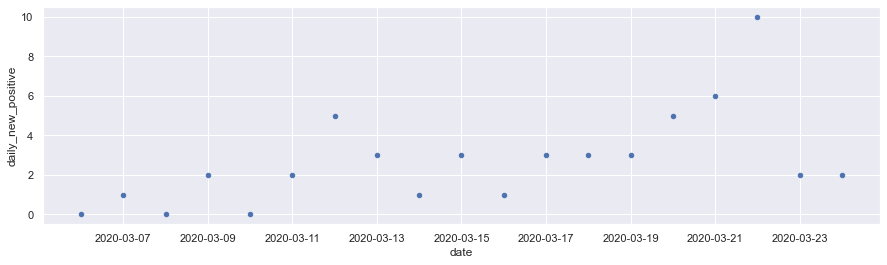

State=ID  (last_update=2020-03-23T19:00)
Doubling every 2.16 days based on last 14 days of data
(naive estimates: current_unresolved=48 hosp=7 icu=1)


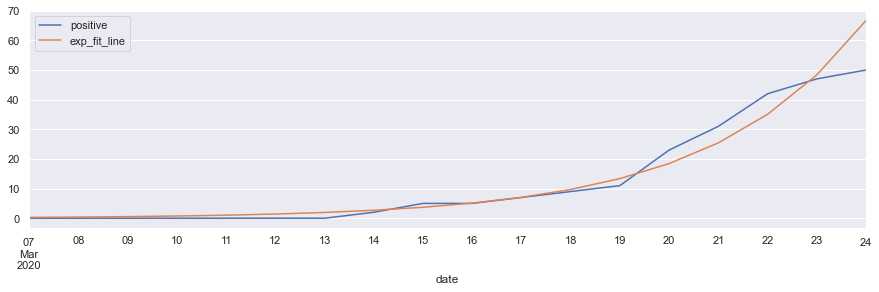

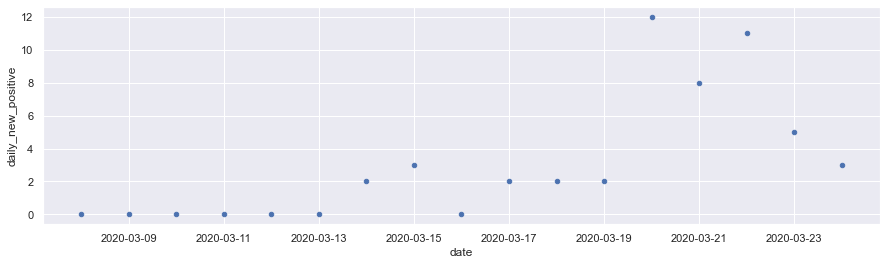

State=MT  (last_update=2020-03-24T10:00)
Doubling every 2.38 days based on last 14 days of data
(naive estimates: current_unresolved=41 hosp=6 icu=1)


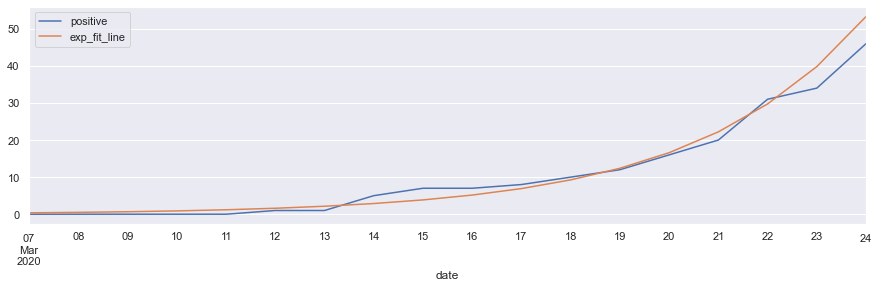

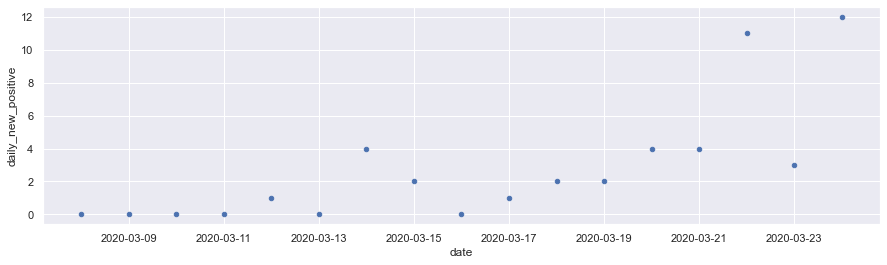

State=PR  (last_update=2020-03-23T07:00)
Doubling every 2.29 days based on last 14 days of data
(naive estimates: current_unresolved=0 hosp=0 icu=0)


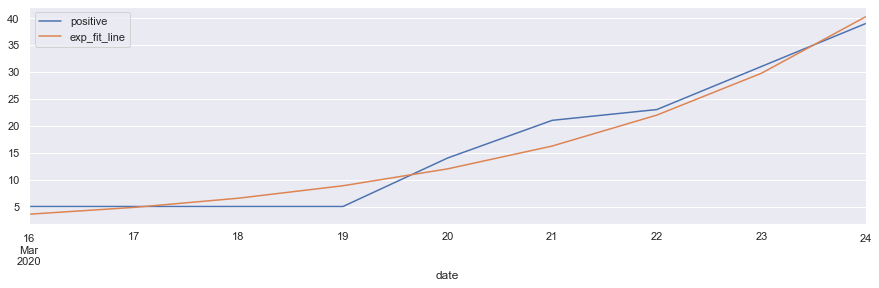

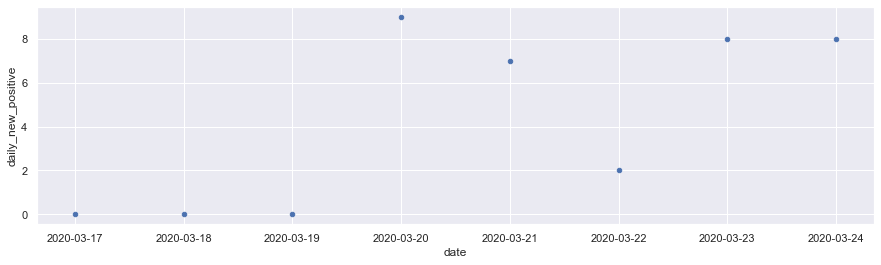

State=AK  (last_update=2020-03-23T19:00)
Doubling every 1.87 days based on last 14 days of data
(naive estimates: current_unresolved=35 hosp=5 icu=1)


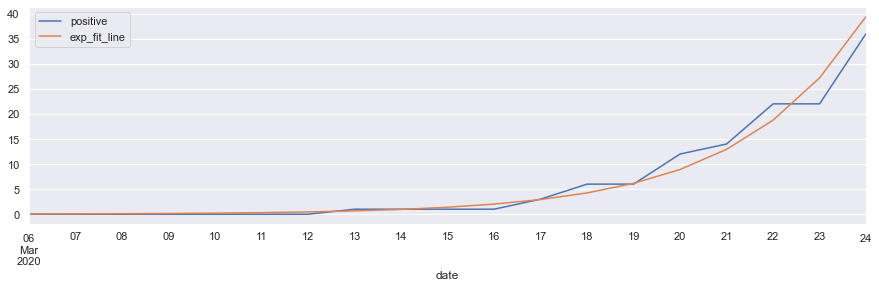

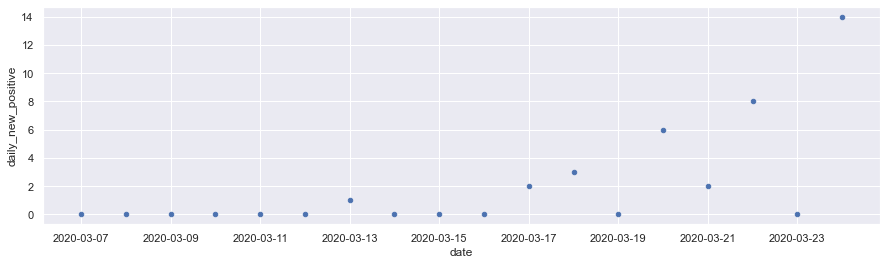

State=ND  (last_update=2020-03-24T11:17)
Doubling every 1.83 days based on last 14 days of data
(naive estimates: current_unresolved=33 hosp=4 icu=1)


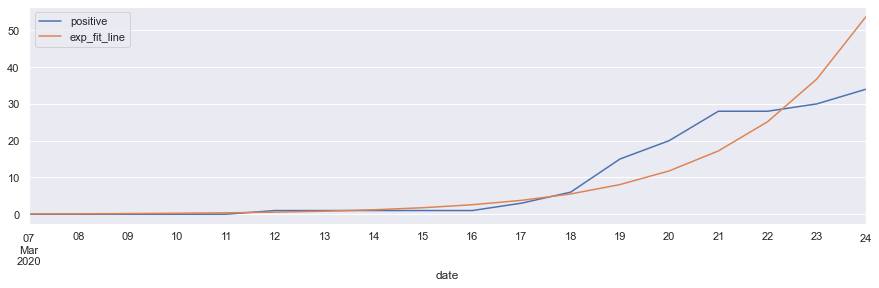

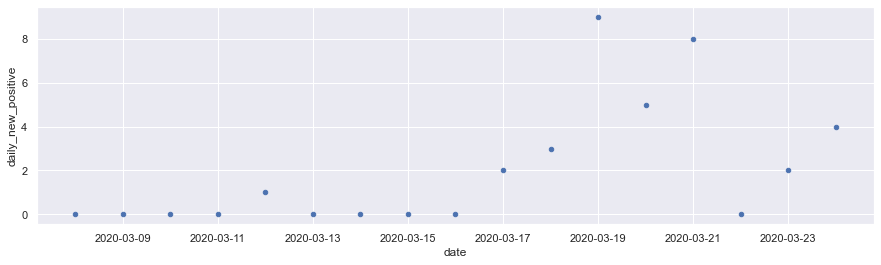

State=GU  (last_update=2020-03-24T06:45)
Doubling every 2.39 days based on last 14 days of data
(naive estimates: current_unresolved=0 hosp=0 icu=0)


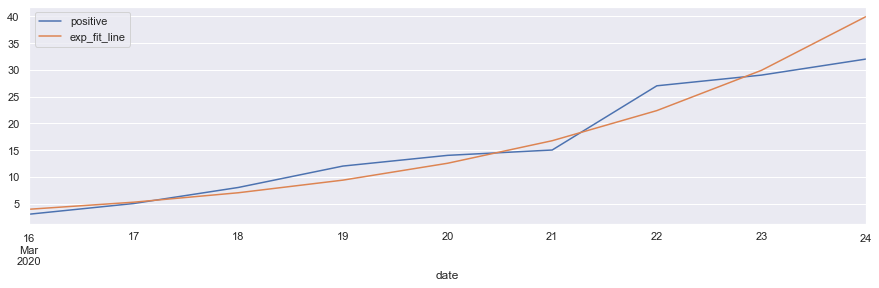

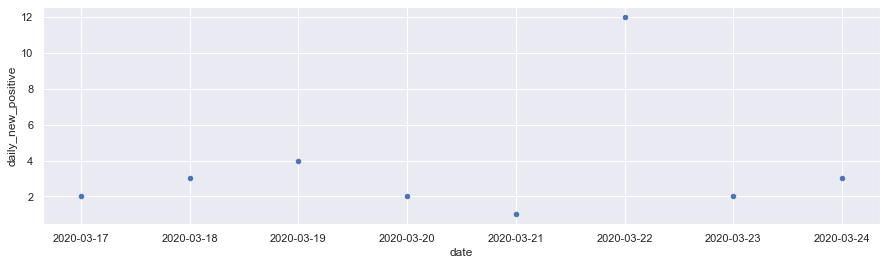

State=SD  (last_update=2020-03-23T10:00)
Doubling every 6.27 days based on last 14 days of data
(naive estimates: current_unresolved=21 hosp=3 icu=0)


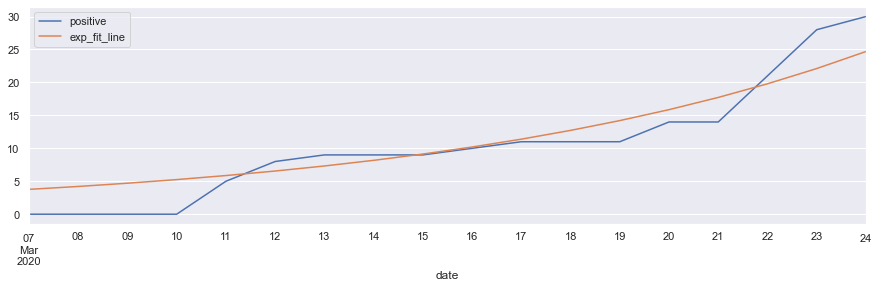

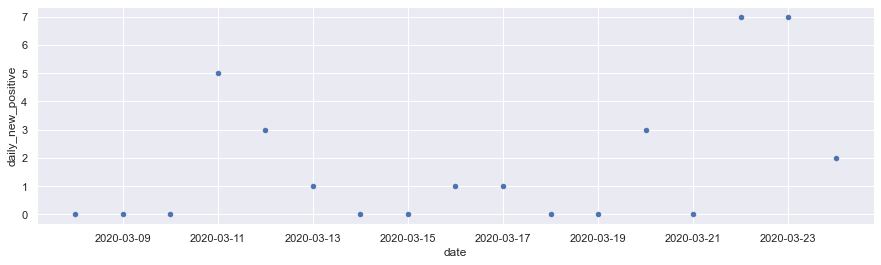

State=WY  (last_update=2020-03-24T13:00)
Doubling every 2.22 days based on last 14 days of data
(naive estimates: current_unresolved=27 hosp=4 icu=1)


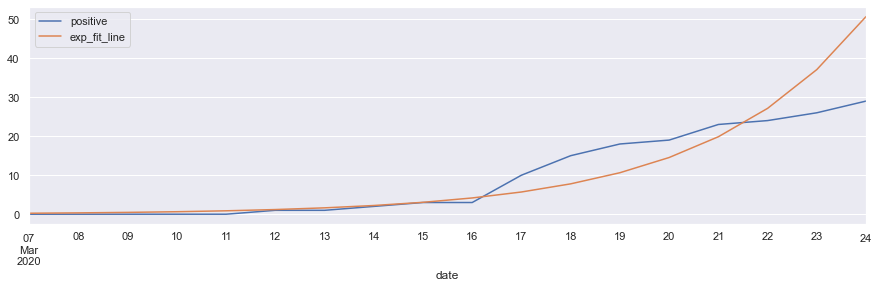

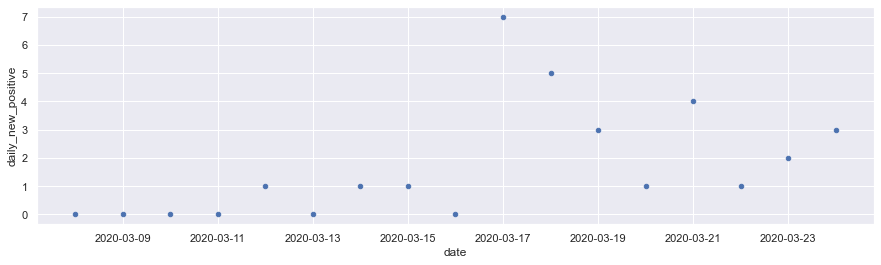

State=WV  (last_update=2020-03-23T00:00)
Doubling every 1.42 days based on last 14 days of data
(naive estimates: current_unresolved=20 hosp=3 icu=0)


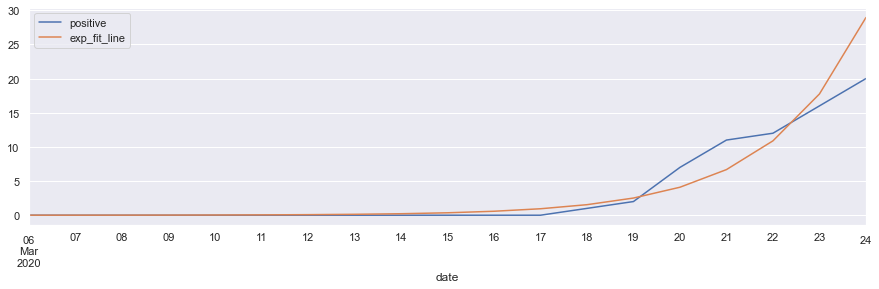

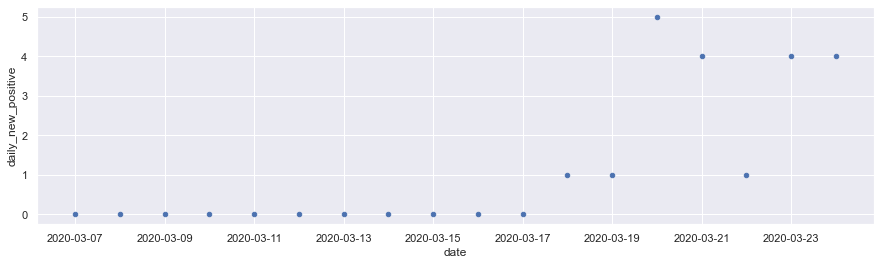

State=VI  (last_update=2020-03-23T20:30)
Doubling every 2.01 days based on last 14 days of data
(naive estimates: current_unresolved=0 hosp=0 icu=0)


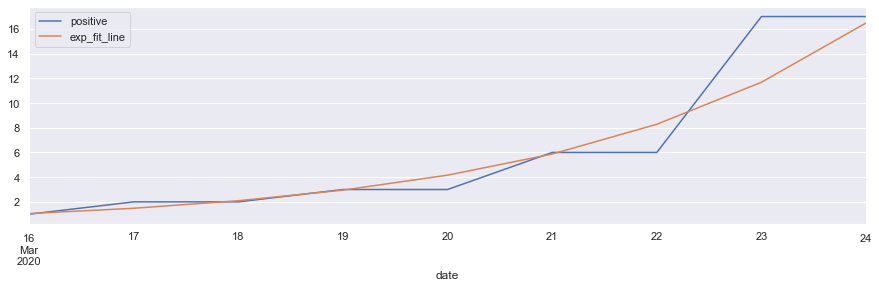

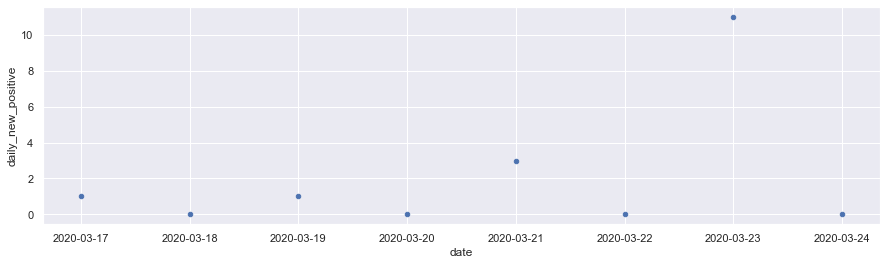

State=AS  (last_update=2020-03-24T00:00)
Doubling every nan days based on last 14 days of data
(naive estimates: current_unresolved=0 hosp=0 icu=0)


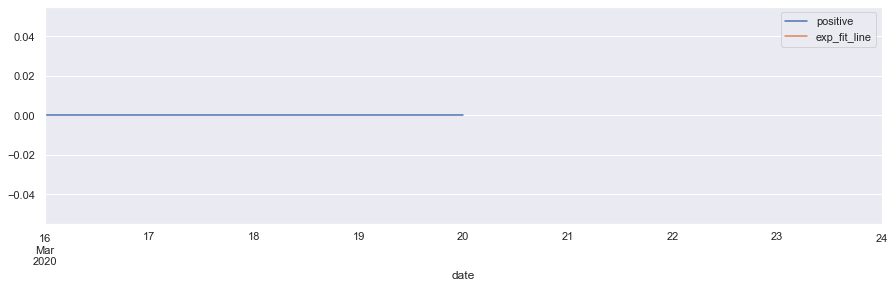

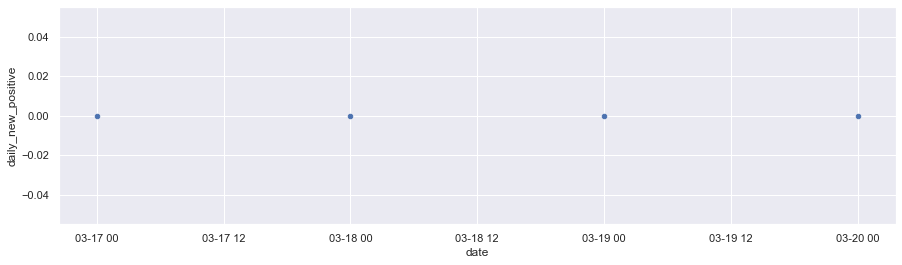

State=MP  (last_update=2020-03-23T01:30)
Doubling every 6.93e+09 days based on last 14 days of data
(naive estimates: current_unresolved=0 hosp=0 icu=0)


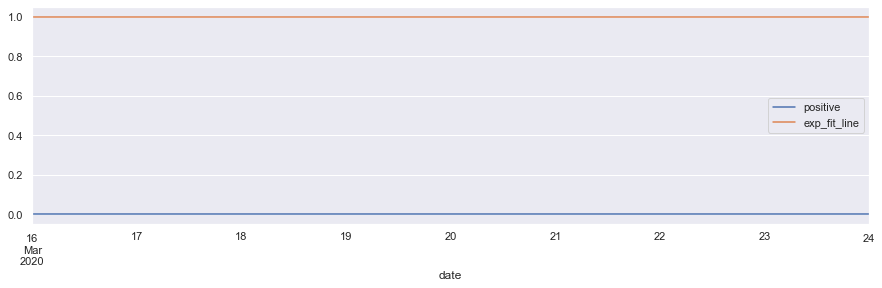

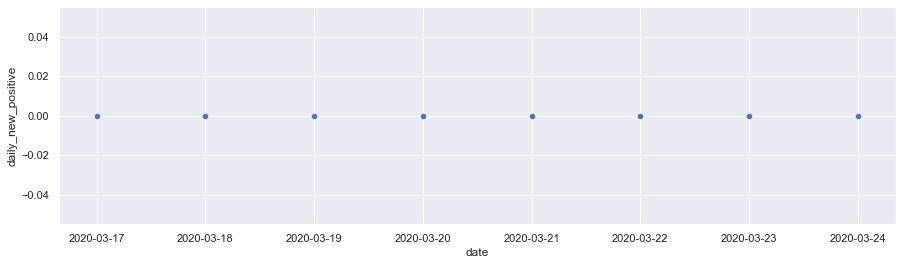

In [13]:
last_n_days = 14
dps = []
for s in states_in_order:
    dfq, dt, lud = get_state_doubling_df(df, s, use_last_n_days=last_n_days)
    dps.append(dt)
    cn, cnh, cni = estimate_current_cases(dfq.daily_new_positive.values)
    lu = str(lud)[:16]
    print("State={}  (last_update={})".format(s, lu))
    print("Doubling every {:.3} days based on last {} days of data".format(dt, last_n_days))
    print("(naive estimates: current_unresolved={} hosp={} icu={})".format(cn, cnh, cni))
    dfq.plot(x="date", y=["positive", "exp_fit_line"], figsize=[15,4])
    if len(dfq) > 1:
        dfq.plot.scatter(x="date", y="daily_new_positive", figsize=[15,4])
    plt.show()

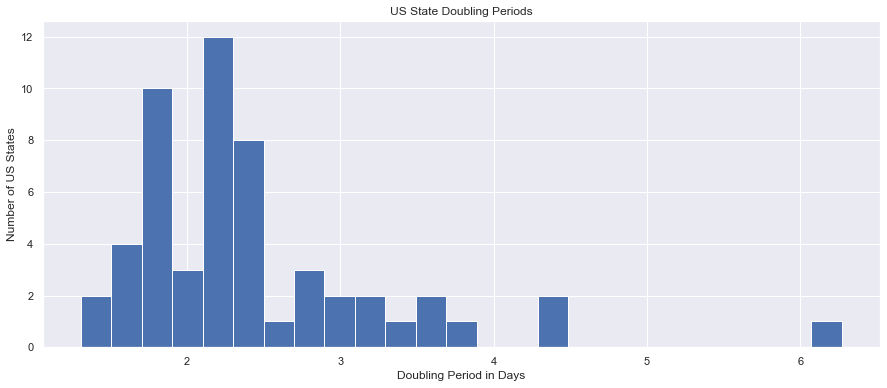

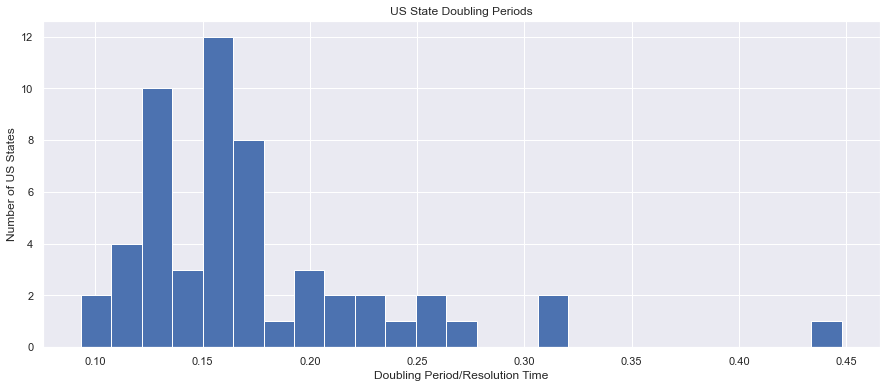

In [14]:
plt.figure(figsize=[15,6])
dps = np.array(dps)
dps = dps[~np.isnan(dps)]
dp_state = dps[dps < 30]
a = plt.hist(dp_state, bins=25)
plt.title("US State Doubling Periods")
plt.xlabel("Doubling Period in Days")
plt.ylabel("Number of US States")
plt.show()
# or in terms of resolution time
plt.figure(figsize=[15,6])
resolution_time = 14
a = plt.hist(dp_state/resolution_time, bins=25)
plt.title("US State Doubling Periods")
plt.xlabel("Doubling Period/Resolution Time")
plt.ylabel("Number of US States")
plt.show()

### Rolling Doubling Period for US

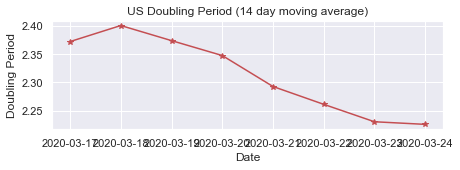

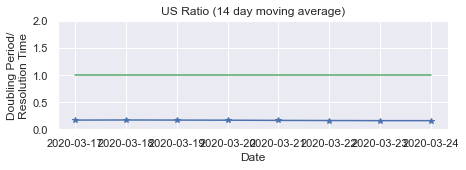

In [15]:
window_size = 14 # days
start_date, end_date = df.date.min(), df.date.max()
delta_t = pd.Timedelta(days=1)
days = int((end_date - start_date).days)
dtv = []
dtt = []
for i in range(days-window_size+2):
    sdt = start_date + i * delta_t
    edt = sdt + window_size * delta_t
    _df = df.loc[(df.date >= sdt) & (df.date < edt)].copy()
    dfa, dt, lud = get_state_doubling_df(_df, "*", use_last_n_days=window_size)
    dtv.append(dt)
    dtt.append(_df.date.values[-1])
plt.figure(figsize=[7,2])
plt.plot(dtt, dtv, "*r-")
plt.title("US Doubling Period ({} day moving average)".format(window_size))
plt.ylabel("Doubling Period")
plt.xlabel("Date")
plt.show()
# by ratio
plt.figure(figsize=[7,2])
plt.plot(dtt, np.array(dtv)/resolution_time, "*b-")
plt.plot(dtt, np.ones(len(dtt)), "g")
plt.title("US Ratio ({} day moving average)".format(window_size))
plt.ylim((0,2))
plt.ylabel("Doubling Period/\nResolution Time")
plt.xlabel("Date")
plt.show()

In [16]:
### Big Grid of Daily Total Cases by State

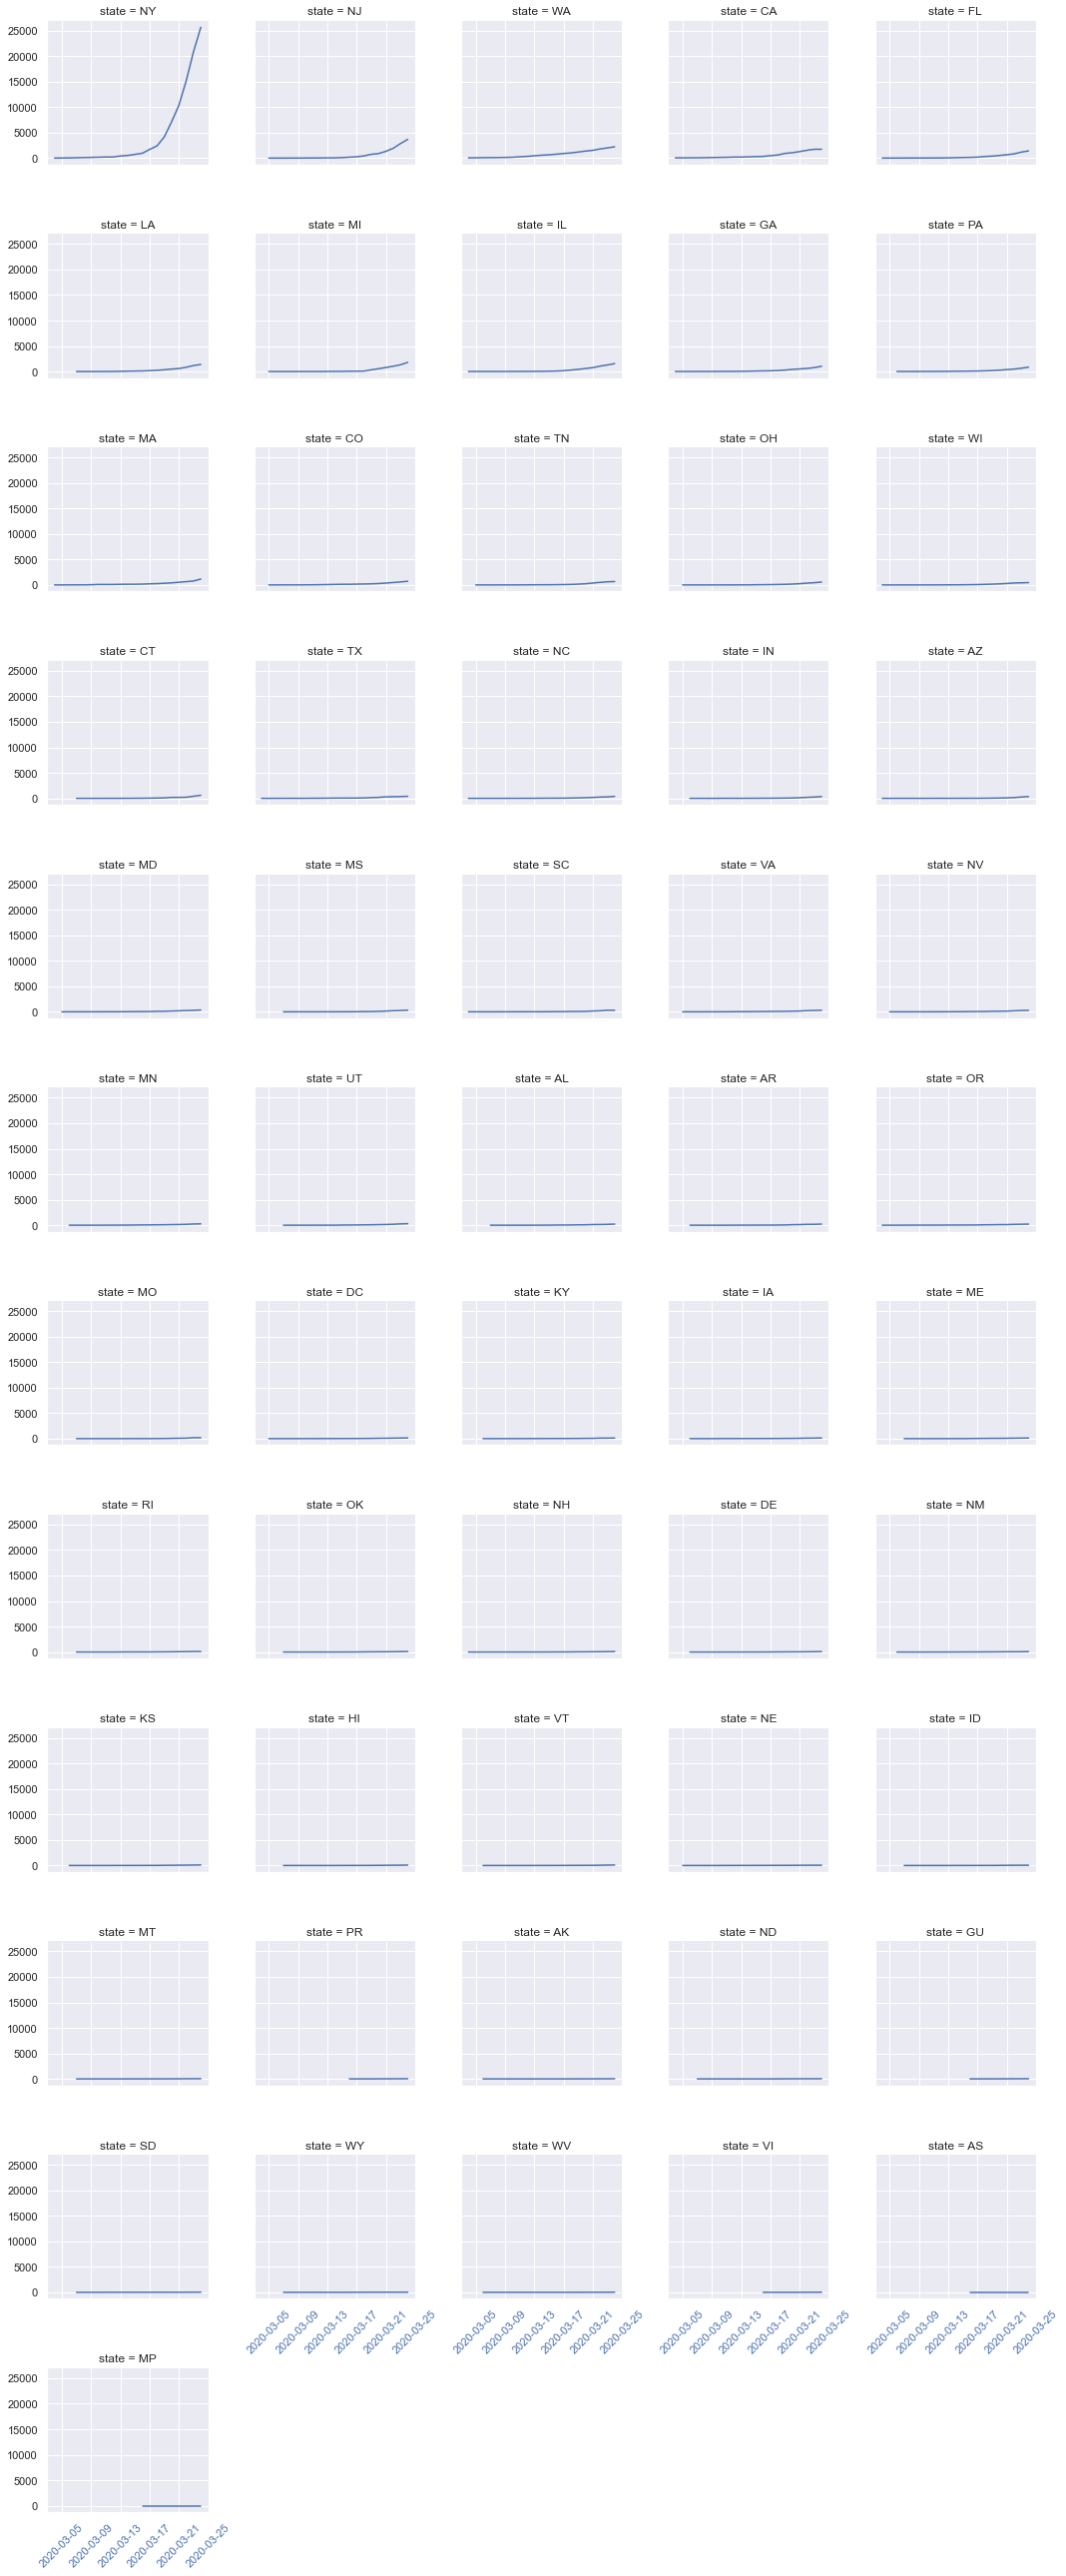

In [17]:
g = sns.FacetGrid(df, col="state", col_wrap=5, height=3, margin_titles=True)
g.map(plt.plot,"date","positive",color="b")
g.map(plt.xticks, rotation=45)